Statistical analysis of 12 vehicles

# Intro

## Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from decimal import Decimal

from co2mpas.datasync import _get_interp_method
import collections

from sklearn import datasets, linear_model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from brokenaxes import brokenaxes

from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

ModuleNotFoundError: No module named 'co2mpas'

 ## Input files

In [ ]:
input_file_1 = 'CO2NOxPN_multipletests.xlsx'
input_file_2 = 'veh_2.xlsx'

CO2NOxPN = pd.read_excel(input_file_1, header=(0, 1, 2))
regulated_pollutants = pd.read_excel(input_file_2, header=(0, 1, 2))

pd.set_option('precision', 3)
# pd.set_option("display.max_columns",54)      #display all the columns of the file

# NOx & PN vs CO2 in different scenarios

## Dataframe

In [ ]:
gsdgsd

## Definitions

In [3]:
# CO2 complete
CO2 = pd.concat([CO2NOxPN.fuel, CO2NOxPN.TA_CO2,
                 CO2NOxPN.xs('CO2', level='pollutant', axis=1)],
                axis=1)
CO2.columns = ['fuel', 'TA_CO2',
               'N_CD_23', 'N-10%_CD_23', 'N+10%_CD_23', 'N_CD_10', 'N_CD_30', 'N_HT_23', 'N_HT_AC18+L_23',
               'W_CD_23', 'W_HT_23', 'W_CD-7', 'W_HT-7',
               'ESP', 'ESD', 'LAB', 'LAD', 'MIL', 'SAC']

# NOx complete
NOx = pd.concat([CO2NOxPN.fuel, CO2NOxPN.TA_CO2,
                 CO2NOxPN.xs('NOx', level='pollutant', axis=1)],
                axis=1)
NOx.columns = ['fuel', 'TA_CO2',
               'N_CD_23', 'N-10%_CD_23', 'N+10%_CD_23', 'N_CD_10', 'N_CD_30', 'N_HT_23', 'N_HT_AC18+L_23',
               'W_CD_23', 'W_HT_23', 'W_CD-7', 'W_HT-7',
               'ESP', 'ESD', 'LAB', 'LAD', 'MIL', 'SAC']

# PN complete
PN = pd.concat([CO2NOxPN.fuel, CO2NOxPN.TA_CO2,
                CO2NOxPN.xs('PN', level='pollutant', axis=1)],
               axis=1)
PN.columns = ['fuel', 'TA_CO2',
              'N_CD_23', 'N-10%_CD_23', 'N+10%_CD_23', 'N_CD_10', 'N_CD_30', 'N_HT_23', 'N_HT_AC18+L_23',
              'W_CD_23', 'W_HT_23', 'W_CD-7', 'W_HT-7',
              'ESP', 'ESD', 'LAB', 'LAD', 'MIL', 'SAC']

# pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx

# pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN
# PN.iloc[:,2:].astype(float)                                  # Show PN in scientific

In [17]:
CO2.mean()

TA_CO2           1.206e+02
N_CD_23          1.385e+02
N-10%_CD_23      1.226e+02
N+10%_CD_23      1.419e+02
N_CD_10          1.438e+02
N_CD_30          1.355e+02
N_HT_23          1.301e+02
N_HT_AC18+L_23   1.539e+02
W_CD_23          1.510e+02
W_HT_23          1.486e+02
W_CD-7           1.825e+02
W_HT-7           1.368e+02
ESP              1.551e+02
ESD              1.676e+02
LAB              1.599e+02
LAD              1.632e+02
MIL              1.463e+02
SAC              1.733e+02
dtype: float64

## Diesel

In [4]:
fuel = 'diesel'

if fuel == 'gasoline':
    NOx_lim = 60
    CO_lim = 1000
    PN_lim = 6e11
else:
    NOx_lim = 80
    CO_lim = 500
    PN_lim = 6e11
    
NOx_NTE = NOx_lim*2.1
PN_NTE = PN_lim*1.5

# 443/2009/EC
CO2_2015 = 130      # target EC for 2015
CO2_2020 = 95       # target EC for 2020


### Averages and frame

In [5]:
fuel = 'diesel'
poll = CO2 

pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx
#pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN


N_COLD = poll[poll['fuel']==fuel].N_CD_23#.mean()
N_HOT = poll[poll['fuel']==fuel].N_HT_23#.mean()
N_realistic = poll[poll['fuel']==fuel].iloc[:,[3,4,5,6,8]].mean(axis=1)                                #.stack().mean()

W_COLD = poll[poll['fuel']==fuel].W_CD_23#.mean()
W_HOT =  poll[poll['fuel']==fuel].W_HT_23#.mean()
W_minus7C = poll[poll['fuel']==fuel]['W_CD-7']#.mean()

RDE = poll[poll['fuel']==fuel].iloc[:,[13,15]].mean(axis=1)                                            #.stack().mean()
non_RDE = poll[poll['fuel']==fuel].iloc[:,[14,16,17,18]].mean(axis=1)                                  #.stack().mean()

#pd.set_option('display.float_format', lambda x: '%.1f' % x)   # use this to how PN

CO2_die_avgs = pd.DataFrame([N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE])
CO2_die_avgs = CO2_die_avgs.T
CO2_die_avgs.columns = ['N_COLD','N_HOT','N_realistic','W_COLD','W_HOT','W_minus7C','RDE','non_RDE']
CO2_die_avgs#.describe()


,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
BMW 530d,142.61,136.67,150.14,145.66,146.02,nan,155.73,175.35
Citroen Cactus,114.36,110.95,118.59,143.45,140.56,nan,130.18,134.96
Fiat 500x,191.55,178.31,157.17,189.63,182.93,nan,194.55,204.58
Porsche Cayenne,197.61,180.91,206.45,217.88,211.22,270.57,214.65,221.06
VW Golf,122.99,112.80,127.90,135.78,129.39,158.36,160.51,168.53
Audi A3,151.03,143.62,155.11,175.95,177.65,198.34,171.97,183.49
Peugeot Partner,116.54,111.06,131.96,141.47,137.30,nan,139.79,152.30
Kia Sportage,130.46,123.52,135.94,135.52,132.07,nan,157.11,158.71


In [6]:
"""

"""

fuel = 'diesel'
poll = CO2

RDE = poll[poll['fuel']==fuel].iloc[:,[13,15]]#.mean(axis=0)                                            #.stack().mean()
non_RDE = poll[poll['fuel']==fuel].iloc[:,[14,16,17,18]]#.mean(axis=0)                                  #.stack().mean()

N_HOT = poll.N_HT_23
N_COLD = poll.N_CD_23
N_realistic = poll.iloc[:,[3,4,5,6,8]]
N_realistic.mean()
#N_HOT#.mean()
#N_COLD.mean()
a = (N_realistic['N_HT_AC18+L_23'].mean()*100/(N_HOT.mean()))
a
b = (N_HOT.mean()*100/(N_COLD.mean()))
b
# RDE.mean()
# non_RDE.mean()

93.95767829875714

In [7]:
poll = PN
W_COLD = poll.W_CD_23#.mean()
W_HOT =  poll.W_HT_23#.mean()
W_minus7C = poll['W_CD-7']#.mean()

c = (W_minus7C.mean()*100/(W_COLD.mean()))
c

136.55741262439517

In [8]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

In [9]:
fuel = 'diesel'
poll = NOx 

pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx
#pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN

N_COLD = poll[poll['fuel']==fuel].N_CD_23#.mean()
N_HOT = poll[poll['fuel']==fuel].N_HT_23#.mean()
N_realistic = poll[poll['fuel']==fuel].iloc[:,[3,4,5,6,8]].mean(axis=1)                                #.stack().mean()

W_COLD = poll[poll['fuel']==fuel].W_CD_23#.mean()
W_HOT =  poll[poll['fuel']==fuel].W_HT_23#.mean()
W_minus7C = poll[poll['fuel']==fuel]['W_CD-7']#.mean()

RDE = poll[poll['fuel']==fuel].iloc[:,[13,15]].mean(axis=1)                                            #.stack().mean()
non_RDE = poll[poll['fuel']==fuel].iloc[:,[14,16,17,18]].mean(axis=1)                                  #.stack().mean()

#pd.set_option('display.float_format', lambda x: '%.1f' % x)   # use this to how PN

NOx_die_avgs = pd.DataFrame([N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE])
NOx_die_avgs = NOx_die_avgs.T
NOx_die_avgs.columns = ['N_COLD','N_HOT','N_realistic','W_COLD','W_HOT','W_minus7C','RDE','non_RDE']
NOx_die_avgs#.describe()

"""
T-TEST between N_COLD and N_HOT
"""
tt = ttest_ind(NOx_die_avgs.N_COLD, NOx_die_avgs.N_realistic) 
tt

# since P-value is big, N_COLD and N_HOT means are not statistically different

Ttest_indResult(statistic=-0.94967053580511418, pvalue=0.35838668609429991)

In [15]:
NOx_die_avgs#.describe()

,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
BMW 530d,15.07,11.81,17.78,12.71,9.66,nan,29.22,39.11
Citroen Cactus,29.16,73.27,71.98,54.71,55.14,nan,461.39,481.82
Fiat 500x,196.05,255.54,201.76,519.02,644.20,nan,601.29,639.14
Porsche Cayenne,41.83,136.29,119.82,150.57,188.12,632.75,298.82,376.42
VW Golf,17.11,26.60,30.23,51.04,50.60,170.00,147.31,423.16
Audi A3,67.01,87.23,104.16,222.20,310.06,373.97,340.73,325.81
Peugeot Partner,13.57,14.60,21.26,47.71,33.74,nan,488.54,692.79
Kia Sportage,38.78,35.10,84.64,185.04,173.13,nan,687.40,830.85


In [10]:
N_HOT = poll.N_HT_23
N_COLD = poll.N_CD_23
N_realistic = poll.iloc[:,[3,4,5,6,8]]
N_realistic.mean()
#N_COLD.mean()
a = (N_realistic['N_CD_10'].mean()*100/(N_COLD.mean()))-100
a
# b = (N_HOT.mean()*100/(N_COLD.mean()))
# b

112.56210536634924

In [11]:
fuel = 'diesel'
poll = PN 

# pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx
pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN

N_COLD = poll[poll['fuel']==fuel].N_CD_23#.mean()
N_HOT = poll[poll['fuel']==fuel].N_HT_23#.mean()
N_realistic = poll[poll['fuel']==fuel].iloc[:,[3,4,5,6,8]].mean(axis=1)                                #.stack().mean()

W_COLD = poll[poll['fuel']==fuel].W_CD_23#.mean()
W_HOT =  poll[poll['fuel']==fuel].W_HT_23#.mean()
W_minus7C = poll[poll['fuel']==fuel]['W_CD-7']#.mean()

RDE = poll[poll['fuel']==fuel].iloc[:,[13,15]].mean(axis=1)                                            #.stack().mean()
non_RDE = poll[poll['fuel']==fuel].iloc[:,[14,16,17,18]].mean(axis=1)                                  #.stack().mean()

#pd.set_option('display.float_format', lambda x: '%.1f' % x)   # use this to how PN

PN_die_avgs = pd.DataFrame([N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE])
PN_die_avgs = PN_die_avgs.T
PN_die_avgs.columns = ['N_COLD','N_HOT','N_realistic','W_COLD','W_HOT','W_minus7C','RDE','non_RDE']
PN_die_avgs                #.mean()           #.std()              #.describe()

# "{:.2E}".format(Decimal(RDE))

,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
BMW 530d,2.800e+10,5.270e+10,5.847e+10,6.730e+10,1.750e+10,nan,7.360e+10,5.392e+10
Citroen Cactus,1.220e+10,1.790e+09,4.475e+09,3.840e+09,1.630e+09,nan,nan,nan
Fiat 500x,3.020e+11,2.200e+11,4.413e+09,2.040e+10,1.370e+09,nan,nan,nan
Porsche Cayenne,4.060e+10,4.330e+10,2.885e+10,4.110e+10,5.520e+10,1.160e+11,nan,nan
VW Golf,1.650e+09,1.270e+09,1.239e+10,1.990e+11,1.660e+09,1.310e+11,nan,nan
Audi A3,5.010e+10,1.150e+10,1.320e+11,8.788e+11,6.677e+09,8.290e+10,nan,nan
Peugeot Partner,3.560e+10,1.140e+10,5.355e+09,6.940e+09,8.040e+09,nan,nan,nan
Kia Sportage,2.653e+09,1.814e+09,8.308e+09,3.306e+09,2.250e+09,nan,4.956e+09,1.297e+09


In [12]:
N_HOT = poll.N_HT_23
N_COLD = poll.N_CD_23
N_realistic = poll.iloc[:,[3,4,5,6,8]]
N_realistic.mean()
#N_COLD.mean()
a = (N_realistic['N_CD_10'].mean()*100/(N_COLD.mean()))
a
# b = (N_HOT.mean()*100/(N_COLD.mean()))
# b

71.88761562383442

In [93]:
N_COLD

Audi A1             784000000000
BMW 530d             28000000000
Citroen Cactus       12200000000
Fiat 500x           302000000000
Opel Astra         4084000000000
Fiat Panda          174000000000
Porsche Cayenne      40600000000
VW Golf               1650000000
Audi A3              50100000000
Peugeot Partner      35600000000
Renault Twingo      218100000000
Kia Sportage          2653000000
Name: N_CD_23, dtype: int64

In [13]:
NOx_CO2_PN = pd.concat([CO2_die_avgs.mean(),
                        NOx_die_avgs.mean(),
                        PN_die_avgs.mean()],axis=1)
NOx_CO2_PN = NOx_CO2_PN.T
NOx_CO2_PN.index = ['CO2','NOx','PN']
NOx_CO2_PN.loc['ABC'] = ['a','b','c','d','e','f','g','h']
NOx_CO2_PN

,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
CO2,1.459e+02,1.372e+02,1.479e+02,1.607e+02,1.571e+02,2.091e+02,1.656e+02,1.749e+02
NOx,5.232e+01,8.006e+01,8.145e+01,1.554e+02,1.831e+02,3.922e+02,3.818e+02,4.761e+02
PN,5.910e+10,4.297e+10,3.178e+10,1.526e+11,1.179e+10,1.100e+11,3.928e+10,2.761e+10
ABC,a,b,c,d,e,f,g,h


### Plot NOx vs CO2

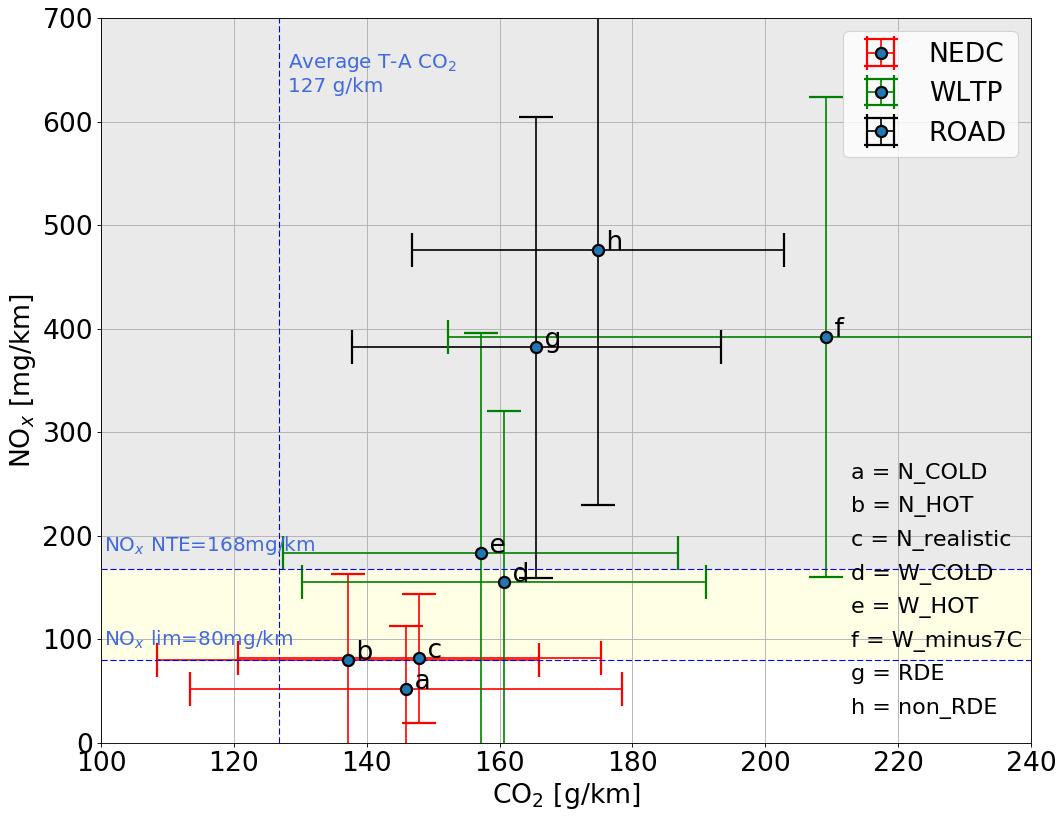

In [17]:
fontsize = 24
TA = 126.875  # diesel cars avg

lim_inf_NOx = 0
lim_sup_NOx = 700
lim_inf_CO2 = 100
lim_sup_CO2 = 240

plt.figure(figsize=(15,12), dpi=80)

# plt.scatter(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['NOx'][0:3],marker='^', alpha=.8 ,s = 60, c = 'black')   # NEDC
# plt.scatter(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['NOx'][3:6],marker='^', alpha=.8 ,s = 60, c = 'red')     # WLTP
# plt.scatter(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['NOx'][6:8],marker='^', alpha=.8 ,s = 60, c = 'green')   # ROAD 

plt.errorbar(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['NOx'][0:3],
             yerr=NOx_die_avgs.std()[0:3],xerr=CO2_die_avgs.std()[0:3],
             fmt='o',ecolor='r', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC
plt.errorbar(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['NOx'][3:6],
             yerr=NOx_die_avgs.std()[3:6],xerr=CO2_die_avgs.std()[3:6],
             fmt='o',ecolor='g', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC     # WLTP
plt.errorbar(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['NOx'][6:8],
             yerr=NOx_die_avgs.std()[6:8],xerr=CO2_die_avgs.std()[6:8],
             fmt='o',ecolor='k', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC   # ROAD 

legend = ('NEDC','WLTP','ROAD')
plt.legend(legend, fontsize = fontsize, loc = 'upper right')


plt.ylabel('NO$_x$ [mg/km]', fontsize = fontsize)
plt.xlabel('CO$_2$ [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
#plt.title('NOx vs CO2 in lab and road tests (all)', fontsize = fontsize)
#plt.axis([90,200,0, 160])

for i, txt in enumerate(NOx_CO2_PN.loc['ABC']):
    plt.annotate(' ' + txt , (NOx_CO2_PN.loc['CO2'][i],NOx_CO2_PN.loc['NOx'][i]), ha = 'left', fontsize = 24)

i = 0
for each in NOx_CO2_PN.columns:
    plt.gcf().text(0.75, 0.4 - 0.035*i, NOx_CO2_PN.loc['ABC'][i] + ' = ' + each , fontsize=20) # .split('36_')[1].split('_2017')[0]
    i = i+1    

    
plt.annotate('Average T-A CO$_2$ \n127 g/km',(TA+0.01*TA, lim_sup_NOx-0.1*lim_sup_NOx),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)
plt.annotate('NO$_x$ NTE=' + str(round(NOx_NTE)) + 'mg/km',(lim_inf_CO2 + 0.003*(lim_sup_CO2-lim_inf_CO2), NOx_NTE + 0.024*lim_sup_NOx),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)
plt.annotate('NO$_x$ lim=' + str(NOx_lim) + 'mg/km',(lim_inf_CO2 + 0.003*(lim_sup_CO2-lim_inf_CO2), NOx_lim + 0.02*lim_sup_NOx),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)
    
plt.axvline(x=TA, color='b', linestyle='--', linewidth=1 )
plt.axhline(y=NOx_lim, color='b', linestyle='--', linewidth=1 )
plt.axhline(y=NOx_NTE, color='b', linestyle='--', linewidth=1 )
plt.axhspan(NOx_lim, NOx_NTE, facecolor='yellow', alpha=0.1)
plt.axhspan(NOx_NTE, lim_sup_NOx, facecolor='0.2', alpha=0.1)
#plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)



plt.axis([lim_inf_CO2,lim_sup_CO2,lim_inf_NOx,lim_sup_NOx])

plt.grid(True)


### Plot PN vs CO2

[120, 240, 0, 200000000000.0]

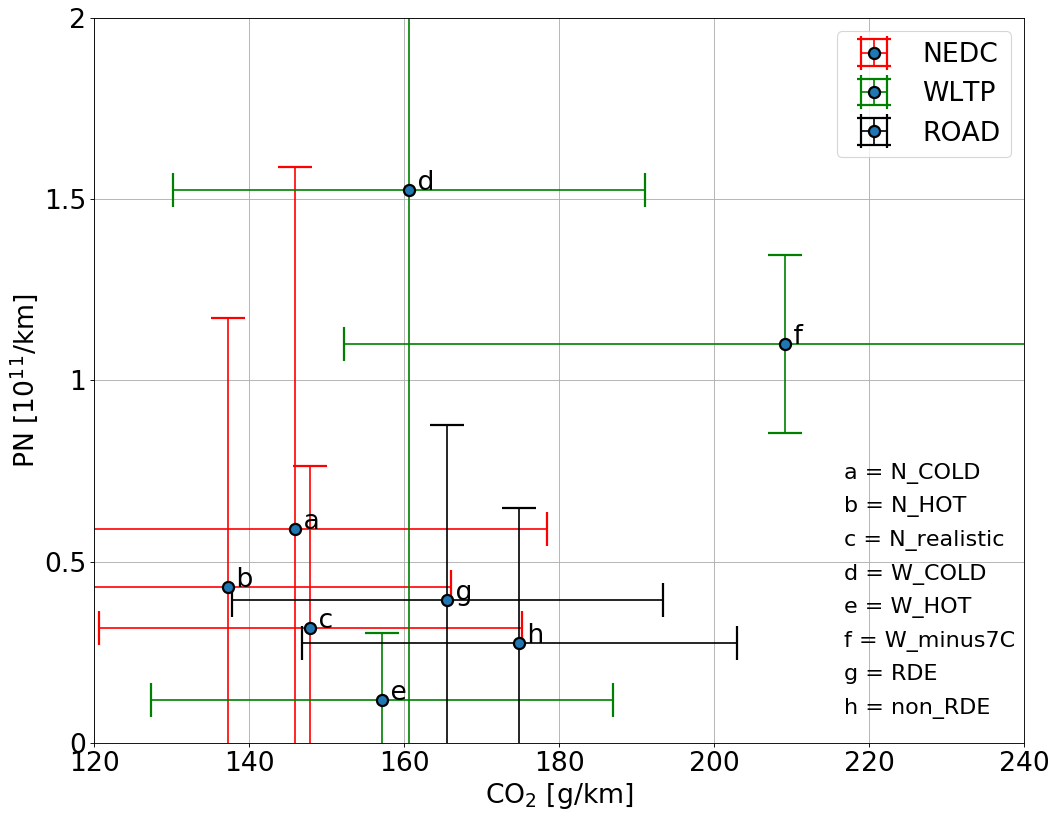

In [19]:
fontsize = 24
TA = 126.875  # diesel cars avg

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")     # subindex
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")     # superindex
# "12".translate(SUP)
lim_inf_PN = 0
lim_sup_PN = 2e11
lim_inf_CO2 = 120
lim_sup_CO2 = 240


ax = plt.figure(figsize=(15,12), dpi=80)

# plt.scatter(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['NOx'][0:3],marker='^', alpha=.8 ,s = 60, c = 'black')   # NEDC
# plt.scatter(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['NOx'][3:6],marker='^', alpha=.8 ,s = 60, c = 'red')     # WLTP
# plt.scatter(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['NOx'][6:8],marker='^', alpha=.8 ,s = 60, c = 'green')   # ROAD 

plt.errorbar(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['PN'][0:3],
             xerr=CO2_die_avgs.std()[0:3],yerr=PN_die_avgs.std()[0:3],
             fmt='o',ecolor='r', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC
plt.errorbar(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['PN'][3:6],
             xerr=CO2_die_avgs.std()[3:6],yerr=PN_die_avgs.std()[3:6],
             fmt='o',ecolor='g', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC     # WLTP
plt.errorbar(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['PN'][6:8],
             xerr=CO2_die_avgs.std()[6:8],yerr=PN_die_avgs.std()[6:8],
             fmt='o',ecolor='k', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC   # ROAD 

legend = ('NEDC','WLTP','ROAD')
plt.legend(legend, fontsize = fontsize, loc = 'upper right')


plt.ylabel('PN [10$^1$$^1$/km]',fontsize=fontsize)             #('PN [10' + "11".translate(SUP) + '/km]', fontsize = fontsize)
plt.xlabel('CO$_2$ [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
#plt.title('NOx vs CO2 in lab and road tests (all)', fontsize = fontsize)
#plt.axis([90,200,0, 160])
#set_yscale('log')
plt.grid(True)

#plt.yscale('log', nonposy='clip')

for i, txt in enumerate(NOx_CO2_PN.loc['ABC']):
    plt.annotate(' ' + txt , (NOx_CO2_PN.loc['CO2'][i],NOx_CO2_PN.loc['PN'][i]), ha = 'left', fontsize = 24)

i = 0
for each in NOx_CO2_PN.columns:
    plt.gcf().text(0.75, 0.4 - 0.035*i, NOx_CO2_PN.loc['ABC'][i] + ' = ' + each , fontsize=20) # .split('36_')[1].split('_2017')[0]
    i = i+1    

# ytick = [-1e11,0,1e11,2e11,3e11,4e11]
# labels = [-1,0,1,2,3,4]

ytick = [0,0.5e11,1e11,1.5e11,2e11]
labels = [0,0.5,1,1.5,2]
plt.yticks(ytick,labels)
plt.axis([lim_inf_CO2,lim_sup_CO2,lim_inf_PN,lim_sup_PN])

# plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
# plt.axhline(y=PN_lim, color='k', linestyle='--', linewidth=2 )
# plt.axhline(y=PN_CF, color='k', linestyle='--', linewidth=2 )
#plt.axhspan(NOx_lim, NOx_lim*2.1, facecolor='yellow', alpha=0.1)
#plt.axhspan(NOx_lim*2.1, lim_sup_NOx, facecolor='0.2', alpha=0.1)
#plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)

In [268]:
pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN
PN_die_avgs#.mean()


,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
BMW 530d,2.800e+10,5.270e+10,5.847e+10,6.730e+10,1.750e+10,nan,7.360e+10,5.392e+10
Citroen Cactus,1.220e+10,1.790e+09,4.475e+09,3.840e+09,1.630e+09,nan,nan,nan
Fiat 500x,3.020e+11,2.200e+11,4.413e+09,2.040e+10,1.370e+09,nan,nan,nan
Porsche Cayenne,4.060e+10,4.330e+10,2.885e+10,4.110e+10,5.520e+10,1.160e+11,nan,nan
VW Golf,1.650e+09,1.270e+09,1.239e+10,1.990e+11,1.660e+09,1.310e+11,nan,nan
Audi A3,5.010e+10,1.150e+10,1.320e+11,8.788e+11,6.677e+09,8.290e+10,nan,nan
Peugeot Partner,3.560e+10,1.140e+10,5.355e+09,6.940e+09,8.040e+09,nan,nan,nan
Kia Sportage,2.653e+09,1.814e+09,8.308e+09,3.306e+09,2.250e+09,nan,4.956e+09,1.297e+09


## Gasoline

### Averages and frame

In [20]:
fuel = 'gasoline'
poll = CO2 

pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx
#pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN


N_COLD = poll[poll['fuel']==fuel].N_CD_23#.mean()
N_HOT = poll[poll['fuel']==fuel].N_HT_23#.mean()
N_realistic = poll[poll['fuel']==fuel].iloc[:,[3,4,5,6,8]].mean(axis=1)                                #.stack().mean()

W_COLD = poll[poll['fuel']==fuel].W_CD_23#.mean()
W_HOT =  poll[poll['fuel']==fuel].W_HT_23#.mean()
W_minus7C = poll[poll['fuel']==fuel]['W_CD-7']#.mean()

RDE = poll[poll['fuel']==fuel].iloc[:,[13,15]].mean(axis=1)                                            #.stack().mean()
non_RDE = poll[poll['fuel']==fuel].iloc[:,[14,16,17,18]].mean(axis=1)                                  #.stack().mean()

#pd.set_option('display.float_format', lambda x: '%.1f' % x)   # use this to how PN

CO2_avgs = pd.DataFrame([N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE])
CO2_avgs = CO2_avgs.T
CO2_avgs.columns = ['N_COLD','N_HOT','N_realistic','W_COLD','W_HOT','W_minus7C','RDE','non_RDE']
CO2_avgs.describe()


,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
count,4.00,4.00,4.00,4.00,4.00,2.00,4.00,4.00
mean,123.75,115.97,132.52,131.81,131.60,142.70,141.40,146.89
std,7.40,5.81,9.18,5.67,8.58,5.36,12.46,10.69
min,115.01,109.23,120.53,124.36,123.46,138.91,125.18,131.72
25%,118.94,112.74,129.77,128.95,125.77,140.81,137.77,144.01
50%,124.72,115.87,133.34,133.06,130.09,142.70,142.43,149.68
75%,129.52,119.10,136.08,135.92,135.92,144.59,146.06,152.56
max,130.54,122.90,142.88,136.75,142.78,146.49,155.56,156.49


In [21]:
fuel = 'gasoline'
poll = NOx 

pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx
#pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN

N_COLD = poll[poll['fuel']==fuel].N_CD_23#.mean()
N_HOT = poll[poll['fuel']==fuel].N_HT_23#.mean()
N_realistic = poll[poll['fuel']==fuel].iloc[:,[3,4,5,6,8]].mean(axis=1)                                #.stack().mean()

W_COLD = poll[poll['fuel']==fuel].W_CD_23#.mean()
W_HOT =  poll[poll['fuel']==fuel].W_HT_23#.mean()
W_minus7C = poll[poll['fuel']==fuel]['W_CD-7']#.mean()

RDE = poll[poll['fuel']==fuel].iloc[:,[13,15]].mean(axis=1)                                            #.stack().mean()
non_RDE = poll[poll['fuel']==fuel].iloc[:,[14,16,17,18]].mean(axis=1)                                  #.stack().mean()

#pd.set_option('display.float_format', lambda x: '%.1f' % x)   # use this to how PN

NOx_avgs = pd.DataFrame([N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE])
NOx_avgs = NOx_avgs.T
NOx_avgs.columns = ['N_COLD','N_HOT','N_realistic','W_COLD','W_HOT','W_minus7C','RDE','non_RDE']
NOx_avgs#.describe()

,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
Audi A1,11.49,3.24,13.39,72.37,76.62,109.12,60.51,37.38
Opel Astra,10.10,8.60,15.13,59.00,82.64,nan,90.45,134.14
Fiat Panda,4.07,3.26,4.99,7.35,4.75,10.77,4.85,8.67
Renault Twingo,4.60,5.36,7.05,9.94,12.48,nan,14.60,13.32


In [17]:
fuel = 'gasoline'
poll = PN 

# pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx
pd.set_option('display.float_format', lambda x: '%.3e' % x)   # use this to how PN

N_COLD = poll[poll['fuel']==fuel].N_CD_23#.mean()
N_HOT = poll[poll['fuel']==fuel].N_HT_23#.mean()
N_realistic = poll[poll['fuel']==fuel].iloc[:,[3,4,5,6,8]].mean(axis=1)                                #.stack().mean()

W_COLD = poll[poll['fuel']==fuel].W_CD_23#.mean()
W_HOT =  poll[poll['fuel']==fuel].W_HT_23#.mean()
W_minus7C = poll[poll['fuel']==fuel]['W_CD-7']#.mean()

RDE = poll[poll['fuel']==fuel].iloc[:,[13,15]].mean(axis=1)                                            #.stack().mean()
non_RDE = poll[poll['fuel']==fuel].iloc[:,[14,16,17,18]].mean(axis=1)                                  #.stack().mean()

#pd.set_option('display.float_format', lambda x: '%.1f' % x)   # use this to how PN

PN_avgs = pd.DataFrame([N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE])
PN_avgs = PN_avgs.T
PN_avgs.columns = ['N_COLD','N_HOT','N_realistic','W_COLD','W_HOT','W_minus7C','RDE','non_RDE']
PN_avgs#.mean()                #.mean()           #.std()              #.describe()

# "{:.2E}".format(Decimal(RDE))

,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
Audi A1,7.840e+11,5.500e+11,1.451e+12,2.370e+12,1.590e+12,3.140e+12,1.150e+12,2.127e+12
Opel Astra,4.084e+12,1.582e+12,nan,3.690e+12,1.720e+12,nan,2.360e+12,2.918e+12
Fiat Panda,1.740e+11,6.070e+10,1.548e+11,2.630e+11,1.710e+11,1.150e+12,4.645e+11,8.578e+11
Renault Twingo,2.181e+11,4.151e+10,3.977e+11,5.758e+11,1.500e+11,nan,6.668e+10,1.952e+11


In [23]:
NOx_CO2_PN = pd.concat([CO2_avgs.mean(),
                        NOx_avgs.mean(),
                        PN_avgs.mean()],axis=1)
NOx_CO2_PN = NOx_CO2_PN.T
NOx_CO2_PN.index = ['CO2','NOx','PN']
NOx_CO2_PN.loc['ABC'] = ['a','b','c','d','e','f','g','h']
NOx_CO2_PN

,N_COLD,N_HOT,N_realistic,W_COLD,W_HOT,W_minus7C,RDE,non_RDE
CO2,1.237e+02,1.160e+02,1.325e+02,1.318e+02,1.316e+02,1.427e+02,1.414e+02,1.469e+02
NOx,7.565e+00,5.117e+00,1.014e+01,3.716e+01,4.412e+01,5.994e+01,4.260e+01,4.838e+01
PN,1.315e+12,5.586e+11,6.679e+11,1.725e+12,9.078e+11,2.145e+12,1.010e+12,1.524e+12
ABC,a,b,c,d,e,f,g,h


### Plot NOx vs CO2

In [24]:
fuel = 'gasoline'

if fuel == 'gasoline':
    NOx_lim = 60
    CO_lim = 1000
    PN_lim = 6e11
else:
    NOx_lim = 80
    CO_lim = 500
    PN_lim = 6e11
    
NOx_NTE = NOx_lim*2.1
PN_NTE = PN_lim*1.5

# 443/2009/EC
CO2_2015 = 130      # target EC for 2015
CO2_2020 = 95       # target EC for 2020


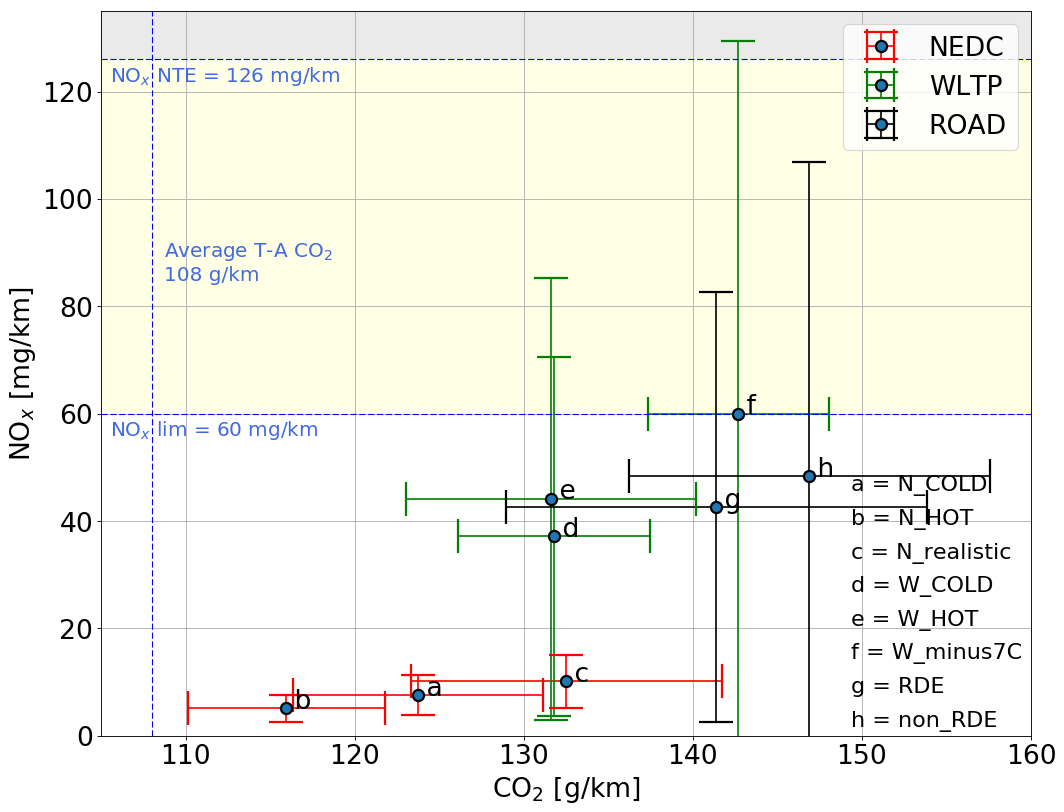

In [26]:
fontsize = 24
TA=108         # gasoline

lim_inf_NOx = 0
lim_sup_NOx = 135
lim_inf_CO2 = 105
lim_sup_CO2 = 160

plt.figure(figsize=(15,12), dpi=80)

# plt.scatter(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['NOx'][0:3],marker='^', alpha=.8 ,s = 60, c = 'black')   # NEDC
# plt.scatter(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['NOx'][3:6],marker='^', alpha=.8 ,s = 60, c = 'red')     # WLTP
# plt.scatter(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['NOx'][6:8],marker='^', alpha=.8 ,s = 60, c = 'green')   # ROAD 

plt.errorbar(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['NOx'][0:3],
             yerr=NOx_avgs.std()[0:3],xerr=CO2_avgs.std()[0:3],
             fmt='o',ecolor='r', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC
plt.errorbar(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['NOx'][3:6],
             yerr=NOx_avgs.std()[3:6],xerr=CO2_avgs.std()[3:6],
             fmt='o',ecolor='g', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC     # WLTP
plt.errorbar(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['NOx'][6:8],
             yerr=NOx_avgs.std()[6:8],xerr=CO2_avgs.std()[6:8],
             fmt='o',ecolor='k', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC   # ROAD 

legend = ('NEDC','WLTP','ROAD')
plt.legend(legend, fontsize = fontsize, loc = 'upper right')


plt.ylabel('NO$_x$ [mg/km]', fontsize = fontsize)
plt.xlabel('CO$_2$ [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
#plt.title('NOx vs CO2 in lab and road tests (all)', fontsize = fontsize)
#plt.axis([90,200,0, 160])

for i, txt in enumerate(NOx_CO2_PN.loc['ABC']):
    plt.annotate(' ' + txt , (NOx_CO2_PN.loc['CO2'][i],NOx_CO2_PN.loc['NOx'][i]), ha = 'left', fontsize = 24)

i = 0
for each in NOx_CO2_PN.columns:
    plt.gcf().text(0.75, 0.38 - 0.035*i, NOx_CO2_PN.loc['ABC'][i] + ' = ' + each , fontsize = 20) # .split('36_')[1].split('_2017')[0]
    i = i+1    
   
plt.annotate('Average T-A CO$_2$ \n108 g/km',(TA+0.007*TA, lim_sup_NOx-0.37*lim_sup_NOx),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)
plt.annotate('NO$_x$ NTE = ' + str(round(NOx_NTE)) + ' mg/km',(lim_inf_CO2 + 0.005*lim_inf_CO2, NOx_NTE - 0.03*lim_sup_NOx),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)
plt.annotate('NO$_x$ lim = ' + str(NOx_lim) + ' mg/km',(lim_inf_CO2 + 0.005*lim_inf_CO2, NOx_lim - 0.03*lim_sup_NOx),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)
    
plt.axvline(x=TA, color='b', linestyle='--', linewidth=1 )
plt.axhline(y=NOx_lim, color='b', linestyle='--', linewidth=1 )
plt.axhline(y=NOx_NTE, color='b', linestyle='--', linewidth=1 )
plt.axhspan(NOx_lim, NOx_NTE, facecolor='yellow', alpha=0.1)
plt.axhspan(NOx_NTE, lim_sup_NOx, facecolor='0.2', alpha=0.1)
#plt.axvspan(lim_inf_CO2, TA, facecolor='green', alpha=0.05)

plt.axis([lim_inf_CO2,lim_sup_CO2,lim_inf_NOx,lim_sup_NOx])
    
plt.grid(True)


### Plot PN vs CO2

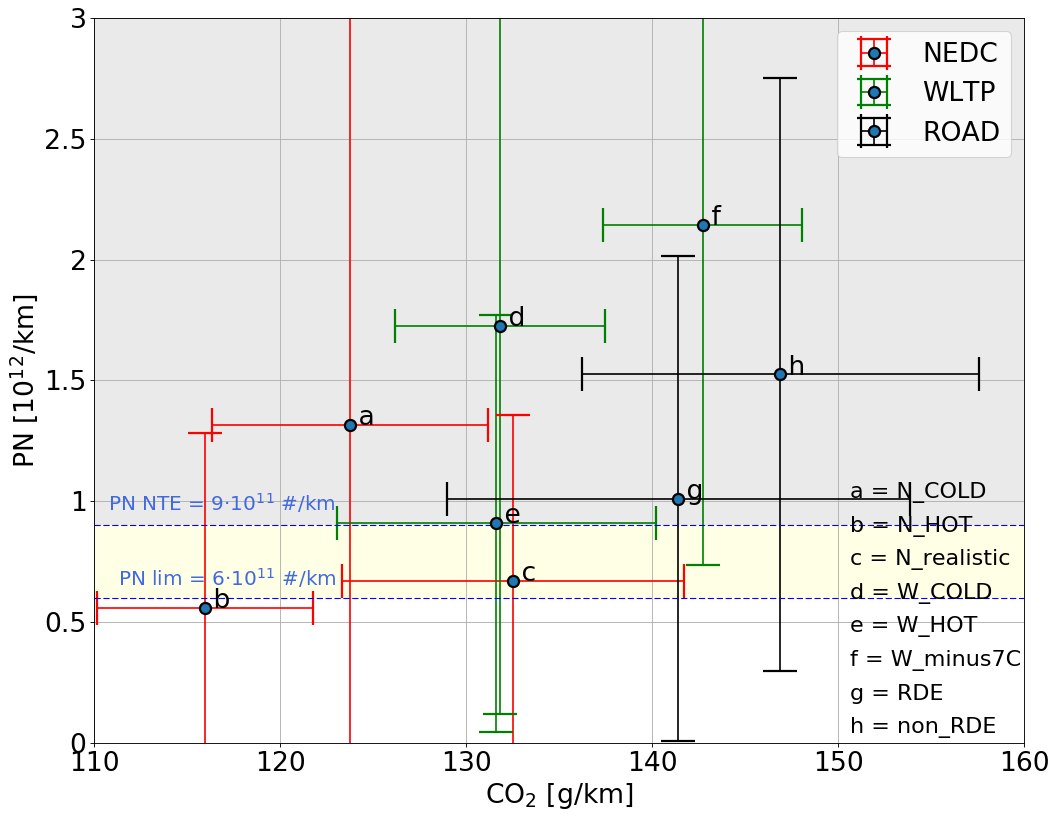

In [34]:
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")     # subindex
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")     # superindex
# "12".translate(SUP)

fontsize = 24
TA = 108

lim_inf_PN = 0
lim_sup_PN = 3e12
lim_inf_CO2 = 110
lim_sup_CO2 = 160

ax = plt.figure(figsize=(15,12), dpi=80)

# plt.scatter(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['NOx'][0:3],marker='^', alpha=.8 ,s = 60, c = 'black')   # NEDC
# plt.scatter(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['NOx'][3:6],marker='^', alpha=.8 ,s = 60, c = 'red')     # WLTP
# plt.scatter(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['NOx'][6:8],marker='^', alpha=.8 ,s = 60, c = 'green')   # ROAD 

plt.errorbar(NOx_CO2_PN.loc['CO2'][0:3], NOx_CO2_PN.loc['PN'][0:3],
             xerr=CO2_avgs.std()[0:3],yerr=PN_avgs.std()[0:3],
             fmt='o',ecolor='r', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC
plt.errorbar(NOx_CO2_PN.loc['CO2'][3:6], NOx_CO2_PN.loc['PN'][3:6],
             xerr=CO2_avgs.std()[3:6],yerr=PN_avgs.std()[3:6],
             fmt='o',ecolor='g', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC     # WLTP
plt.errorbar(NOx_CO2_PN.loc['CO2'][6:8], NOx_CO2_PN.loc['PN'][6:8],
             xerr=CO2_avgs.std()[6:8],yerr=PN_avgs.std()[6:8],
             fmt='o',ecolor='k', capsize = 15,capthick=2,mec='black', ms=10, mew=2)          # NEDC   # ROAD 

legend = ('NEDC','WLTP','ROAD')
plt.legend(legend, fontsize = fontsize, loc = 'upper right')


plt.ylabel('PN [10$^1$$^2$/km]', fontsize = fontsize)                    # 'PN [10' + "12".translate(SUP) + '/km]'
plt.xlabel('CO$_2$ [g/km]', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

for i, txt in enumerate(NOx_CO2_PN.loc['ABC']):
    plt.annotate(' ' + txt , (NOx_CO2_PN.loc['CO2'][i],NOx_CO2_PN.loc['PN'][i]), ha = 'left', fontsize = 24, clip_on=True)

i = 0
for each in NOx_CO2_PN.columns:
    plt.gcf().text(0.755, 0.38 - 0.035*i, NOx_CO2_PN.loc['ABC'][i] + ' = ' + each , fontsize=20, clip_on=True) # .split('36_')[1].split('_2017')[0]
    i = i+1    

plt.annotate('PN NTE = 9·10$^1$$^1$ #/km',(lim_inf_CO2 + 0.015*(lim_sup_CO2-lim_inf_CO2), 6.4*1.5*1e11),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)
plt.annotate('PN lim = 6·10$^1$$^1$ #/km',(lim_inf_CO2 + 0.025*(lim_sup_CO2-lim_inf_CO2),6.5*1e11),
            color='royalblue',textcoords='data', fontsize=18, clip_on=True)    
    
# plt.axvline(x=TA, color='k', linestyle='--', linewidth=2 )
plt.axhline(y=PN_lim, color='b', linestyle='--', linewidth=1 )
plt.axhline(y=PN_NTE, color='b', linestyle='--', linewidth=1 )    
plt.axhspan(PN_lim, PN_NTE, facecolor='yellow', alpha=0.1)
plt.axhspan(PN_NTE, lim_sup_PN, facecolor='0.2', alpha=0.1)

plt.axis([lim_inf_CO2,lim_sup_CO2,lim_inf_PN,lim_sup_PN])

# ytick = [-0.5e12,0,0.5e12,1e12,1.5e12,2e12,2.5e12,3e12,3.5e12]
# labels = [-0.5,0,0.5,1,1.5,2,2.5,3,3.5]
ytick = [0,0.5e12,1e12,1.5e12,2e12,2.5e12,3e12]
labels = [0,0.5,1,1.5,2,2.5,3]

plt.yticks(ytick,labels)

plt.grid(True)

In [547]:
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
"H2SO4".translate(SUB)

'H₂SO₄'

# Regulated pollutants

In [3]:
# CO2 complete
CO2 = pd.concat([regulated_pollutants.fuel,regulated_pollutants.T_A,
                 regulated_pollutants.xs(('CO2','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO2.columns = ['fuel','T-A','NEDC','WLTP','RDE']                 

# CO2 urban
CO2_urb = pd.concat([regulated_pollutants.fuel,#regulated_pollutants.T_A,
                 regulated_pollutants.NEDC.CO2.urban,regulated_pollutants.WLTP.CO2.low,
                 regulated_pollutants.RDE.CO2.urban], axis=1)
CO2_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# CO2 150s (g/KM)
CO2_150d = pd.concat([regulated_pollutants.fuel,#regulated_pollutants.T_A,
                 regulated_pollutants.xs(('CO2','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO2_150d.columns = ['fuel','NEDC','WLTP']

# CO2 150s (g)
CO2_150 = pd.concat([regulated_pollutants.fuel,#regulated_pollutants.T_A,
                 regulated_pollutants.xs(('CO2','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO2_150.columns = ['fuel','NEDC','WLTP','RDE']        
##############




# NOx complete
NOx = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('NOx','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
NOx.columns = ['fuel','NEDC','WLTP','RDE']                 

# NOx urban
NOx_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.NOx.urban,regulated_pollutants.WLTP.NOx.low,
                 regulated_pollutants.RDE.NOx.urban], axis=1)
NOx_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# NOx 150s (g/KM)
NOx_150d= pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('NOx','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
NOx_150d.columns = ['fuel','NEDC','WLTP']

# NOx 150s (g)
NOx_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('NOx','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
NOx_150.columns = ['fuel','NEDC','WLTP','RDE']
##############




# CO complete
CO = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('CO','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO.columns = ['fuel','NEDC','WLTP','RDE']                 

# CO urban
CO_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.CO.urban,regulated_pollutants.WLTP.CO.low,
                 regulated_pollutants.RDE.CO.urban], axis=1)
CO_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# CO 150s (g/KM)
CO_150d = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('CO','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO_150d.columns = ['fuel','NEDC','WLTP'] 

# CO 150s (g)
CO_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('CO','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
CO_150.columns = ['fuel','NEDC','WLTP','RDE']        
##############




# HC complete
HC = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('HC','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
HC.columns = ['fuel','NEDC','WLTP','RDE']                 

# HC urban
HC_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.HC.urban,regulated_pollutants.WLTP.HC.low,
                 regulated_pollutants.RDE.HC.urban], axis=1)
HC_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# HC 150s (g/KM)
HC_150d = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('HC','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
HC_150d.columns = ['fuel','NEDC','WLTP']

# HC 150s (g)
HC_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('HC','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
HC_150.columns = ['fuel','NEDC','WLTP','RDE']
##############




# PN complete
PN = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('PN','complete'), level=('pollutant','phase'),axis=1)],
                 axis=1)
PN.columns = ['fuel','NEDC','WLTP','RDE']                 

# PN urban
PN_urb = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.NEDC.PN.urban,regulated_pollutants.WLTP.PN.low,
                 regulated_pollutants.RDE.PN.urban], axis=1)
PN_urb.columns = ['fuel','UDC','WLTP_Low','RDE_Urb']  

# PN 150s (g/KM)
PN_150d = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('PN','150/d'), level=('pollutant','phase'),axis=1)],
                 axis=1)
PN_150d.columns = ['fuel','NEDC','WLTP']

# PN 150s (g)
PN_150 = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs(('PN','150'), level=('pollutant','phase'),axis=1)],
                 axis=1)
PN_150.columns = ['fuel','NEDC','WLTP','RDE']

In [38]:
# T test - to know if 2 means are statistically different

tt = ttest_ind(NOx_150[NOx_150.fuel=='gasoline'].WLTP,NOx_150[NOx_150.fuel=='gasoline'].RDE)
tt
#PN_150

Ttest_indResult(statistic=-0.89634740009591718, pvalue=0.40459317505629866)

In [4]:
NOx_all = pd.concat([regulated_pollutants.fuel,
                 regulated_pollutants.xs('NOx', level='pollutant',axis=1)],
                 axis=1)

NOx_all.columns = ['fuel',
                   'N_c','N_u','N_e','N_150d','N_150',
                   'W_c','W_l','W_m','W_h','W_eh','W_150d','W_150',
                   'R_c','R_u','R_r','R_m','R_150']

NOx_all[NOx_all.fuel=='diesel'].mean()

N_c        52.317
N_u        51.202
N_e        52.870
N_150d     94.625
N_150      60.972
W_c       155.376
W_l       145.656
W_m       100.120
W_h        69.096
W_eh      265.795
W_150d    189.720
W_150     127.092
R_c       381.839
R_u       291.245
R_r       344.153
R_m       531.979
R_150     295.696
dtype: float64

In [12]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)   # use this to show CO2 or NOx


In [6]:
regulated_pollutants[regulated_pollutants.fuel=='diesel'].RDE['NOx'].describe()#.describe()#[HC.fuel=='diesel']#.describe()

NotImplementedError: merging with more than one level overlap on a multi-index is not implemented

In [205]:
CO_urb#.describe()#[HC_urb.fuel=='diesel']#.describe()

,fuel,UDC,WLTP_Low,RDE_Urb
Audi A1,gasoline,732.33,1542.67,191.66
BMW 530d,diesel,205.55,254.77,47.87
Audi A3,diesel,103.87,114.58,270.81
Citroen Cactus,diesel,913.25,231.71,144.84
Fiat 500x,diesel,180.43,73.29,270.42
Opel Astra,gasoline,515.31,1161.13,456.84
Fiat Panda,gasoline,828.53,1071.12,307.68
Kia Sportage,diesel,810.98,465.57,109.41
Peugeot Partner,diesel,819.68,236.30,79.16
Porsche Cayenne,diesel,362.11,233.00,58.10


In [206]:
CO_150d#.describe()#[HC_150d.fuel=='diesel']#.mean()

,fuel,NEDC,WLTP
Audi A1,gasoline,4265.33,6551.38
BMW 530d,diesel,1112.06,958.83
Audi A3,diesel,638.94,528.34
Citroen Cactus,diesel,4162.68,932.31
Fiat 500x,diesel,839.75,321.12
Opel Astra,gasoline,3132.59,4952.58
Fiat Panda,gasoline,3274.36,4129.06
Kia Sportage,diesel,2710.49,898.27
Peugeot Partner,diesel,3727.09,984.40
Porsche Cayenne,diesel,1966.30,608.32


In [207]:
CO_150#.describe()#[PN_150.fuel=='gasoline']#.describe()

,fuel,NEDC,WLTP,RDE
Audi A1,gasoline,2818.62,4454.18,3832.59
BMW 530d,diesel,724.31,646.43,263.50
Audi A3,diesel,409.32,351.48,95.96
Citroen Cactus,diesel,2732.83,628.12,943.36
Fiat 500x,diesel,535.69,211.79,1838.61
Opel Astra,gasoline,2076.27,3345.38,3725.01
Fiat Panda,gasoline,2158.02,2808.46,1449.26
Kia Sportage,diesel,1772.50,605.03,1238.08
Peugeot Partner,diesel,2447.20,655.68,755.60
Porsche Cayenne,diesel,1258.70,414.38,464.52


## Diesel

### Targets / standards 

In [13]:
fuel = 'diesel'

if fuel == 'gasoline':
    NOx_lim = 60
    CO_lim = 1000
    PN_lim = 6e11
else:
    NOx_lim = 80
    CO_lim = 500
    PN_lim = 6e11
    
NOx_CF = NOx_lim*2.1
PN_CF = PN_lim*1.5

# 443/2009/EC
CO2_2015 = 130      # target EC for 2015
CO2_2020 = 95       # target EC for 2020


### Complete, urban & start (distance-based)

In [28]:
#PN[PN['fuel']=='diesel'].boxplot(showmeans=True,figsize=(10,10),fontsize=15)

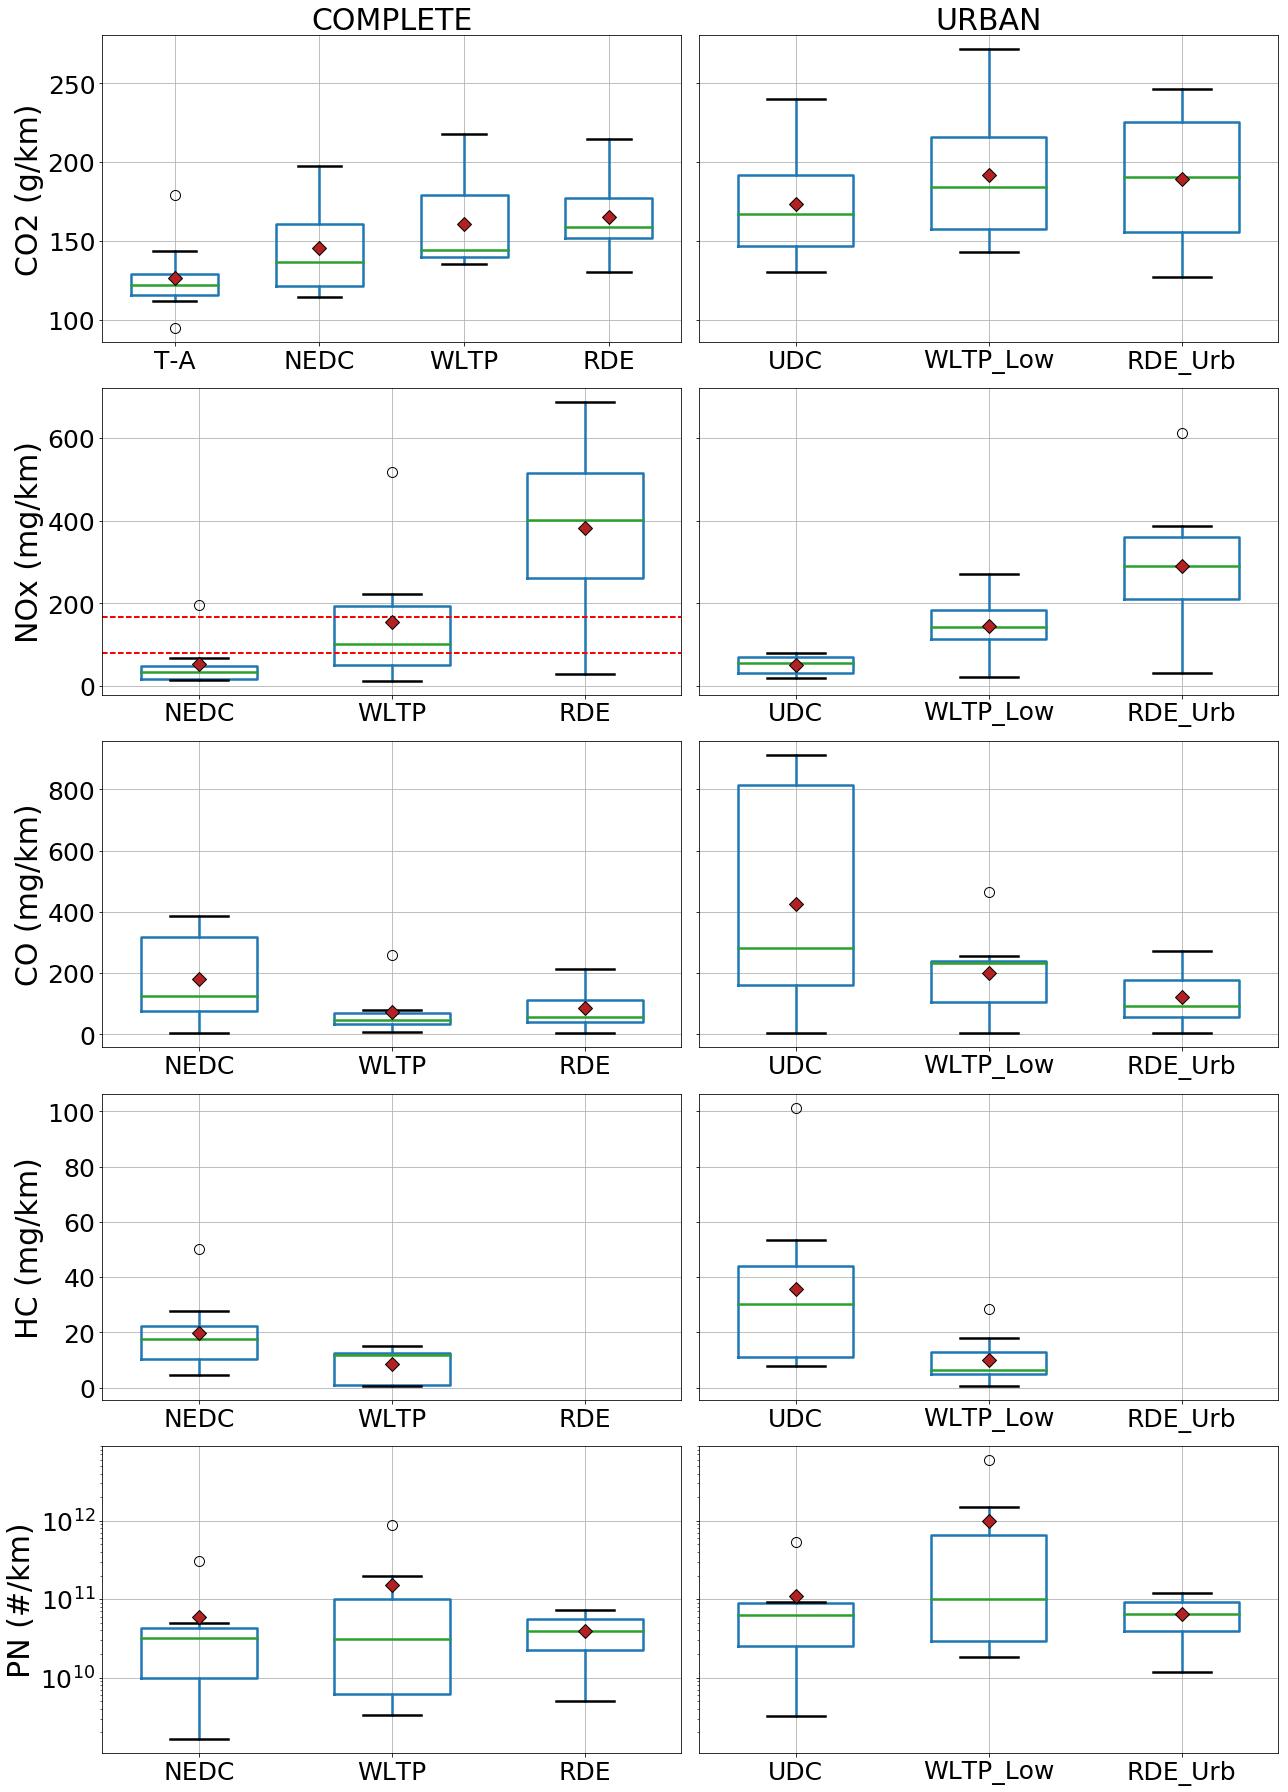

In [374]:
widths = 0.6                                                             # box
fs_ticks = 25                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 30                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')

fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6),
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, sharey='row',
                                         figsize=(18,25))  # sharex='col'

# CO2
CO2[CO2['fuel']=='diesel'].boxplot(ax=ax1, showmeans=True, 
                                   meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                   capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                   widths = widths, fontsize=25) 
CO2_urb[CO2_urb['fuel']=='diesel'].boxplot(ax=ax2, showmeans=True, 
                                           medianprops=medianprops, meanprops=meanpointprops, whiskerprops=whiskerprops, 
                                           capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                           widths = widths, fontsize=25) 
# CO2_150d[CO2_150d['fuel']=='diesel'].boxplot(ax=ax3, showmeans=True, widths = widths, capprops=capprops,
#                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# NOx
NOx[NOx['fuel']=='diesel'].boxplot(ax=ax3, showmeans=True, 
                                   capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                   meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
                                   widths = widths, fontsize=25)
NOx_urb[NOx_urb['fuel']=='diesel'].boxplot(ax=ax4, showmeans=True, 
                                           capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                           meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                           widths = widths, fontsize=25)
# NOx_150d[NOx_150d['fuel']=='diesel'].boxplot(ax=ax6, showmeans=True, widths = widths, capprops=capprops,
#                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

ax3.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )            # limits
ax3.axhline(y=NOx_CF, color='r', linestyle='--', linewidth=2 )             # conformity factor
#ax4.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )
#ax4.axhline(y=NOx_CF, color='r', linestyle='--', linewidth=2 )



# CO
CO[CO['fuel']=='diesel'].boxplot(ax=ax5, showmeans=True, 
                                 capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                 meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
                                 widths = widths, fontsize=25); 
CO_urb[CO_urb['fuel']=='diesel'].boxplot(ax=ax6, showmeans=True, 
                                         capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                         meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                         widths = widths, fontsize=25) 
# CO_150d[CO_150d['fuel']=='diesel'].boxplot(ax=ax9, showmeans=True, widths = widths, capprops=capprops,
#                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# HC
HC[HC['fuel']=='diesel'].boxplot(ax=ax7, showmeans=True, 
                                 capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                 meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                 widths = widths, fontsize=25) 
HC_urb[HC_urb['fuel']=='diesel'].boxplot(ax=ax8, showmeans=True, 
                                         capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                         meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                         widths = widths, fontsize=25) 
# HC_150d[HC_150d['fuel']=='diesel'].boxplot(ax=ax12, showmeans=True, widths = widths, capprops=capprops,
#                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# PN
PN[PN['fuel']=='diesel'].boxplot(ax=ax9, showmeans=True, 
                                 capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                 meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                 widths = widths, fontsize=25) 
PN_urb[PN_urb['fuel']=='diesel'].boxplot(ax=ax10, showmeans=True, 
                                         capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                         meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                         widths = widths, fontsize=25)                              # CHECK outliers!
# PN_150d[PN_150d['fuel']=='diesel'].boxplot(ax=ax15, showmeans=True, showfliers=False, capprops=capprops,
#                                            meanprops=meanpointprops, medianprops=medianprops,
#                                         widths = widths, fontsize=25)                            # CHECK outliers!

# 3 columns
ax1.set_title('COMPLETE', fontsize=30)
ax2.set_title('URBAN', fontsize=30)
#ax3.set_title('START', fontsize=30)

# 5 rows
ax1.set_ylabel('CO2 (g/km)', fontsize=30)
ax3.set_ylabel('NOx (mg/km)', fontsize=30)
ax5.set_ylabel('CO (mg/km)', fontsize=30)
ax7.set_ylabel('HC (mg/km)', fontsize=30)
ax9.set_ylabel('PN (#/km)', fontsize=30)
ax9.set_yscale('log')
ax10.set_yscale('log')


fig.tight_layout()

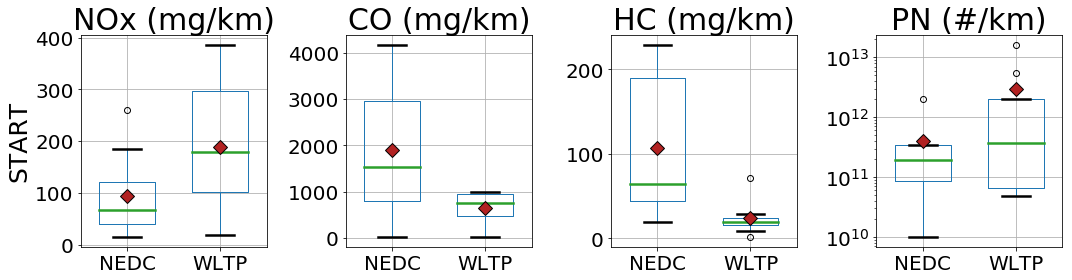

In [79]:
fuel= 'diesel'

widths = 0.6                                                             # box
fs_ticks = 20                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 25                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')


fig, (ax1, ax2, ax3, ax4), = plt.subplots(nrows=1, ncols=4, # sharey='row',
                                         figsize=(15,4))  # sharex='col'

NOx_150d[NOx_150d['fuel']==fuel].boxplot(ax=ax1, showmeans=True, 
                                           capprops=capprops, meanprops=meanpointprops, medianprops=medianprops,
                                           widths = widths, fontsize=fs_ticks)                           # CHECK outliers
CO_150d[CO_150d['fuel']==fuel].boxplot(ax=ax2, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                         medianprops=medianprops,
                                         widths = widths, fontsize=fs_ticks)
HC_150d[HC_150d['fuel']==fuel].boxplot(ax=ax3, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                           medianprops=medianprops, 
                                           fontsize=fs_ticks, widths = widths)
PN_150d[PN_150d['fuel']==fuel].boxplot(ax=ax4, showmeans=True,capprops=capprops, 
                                         meanprops=meanpointprops, medianprops=medianprops, 
                                         widths = widths, fontsize=fs_ticks)                             # CHECK outliers

# Add datapoints
"""
for i,d in enumerate(NOx_150[['NEDC','WLTP','RDE']][NOx_150['fuel']==fuel]):              
    y = NOx_150[['NEDC','WLTP','RDE']][NOx_150['fuel']==fuel][d]
    x = np.random.normal(i+1, 0.04, len(y))
    ax1.plot(x, y, mfc = ["orange","blue","yellow"][i], mec='k', ms=7, marker="o", linestyle="None")
"""

# 1. NOx
ax1.set_title('NOx (mg/km)', fontsize=fs_titles)
ax1.set_ylabel('START', fontsize=fs_labels)
# ax1.set_yticks([0,200,400,600,800,1000])

# 2. CO
ax2.set_title('CO (mg/km)', fontsize=fs_titles)
# ax2.set_yticks([0,500,1000,1500,2000,2500])
# ax2.set_yticks([0,50,100,150,200,250,300])

# 3. HC
ax3.set_title('HC (mg/km)', fontsize=fs_titles)
# ax3.set_yticks([0,25,50,75,100,125,150])

# 4. PN
ax4.set_title('PN (#/km)', fontsize=fs_titles)
ax4.set_yscale('log')

fig.tight_layout()

#### With broken axis

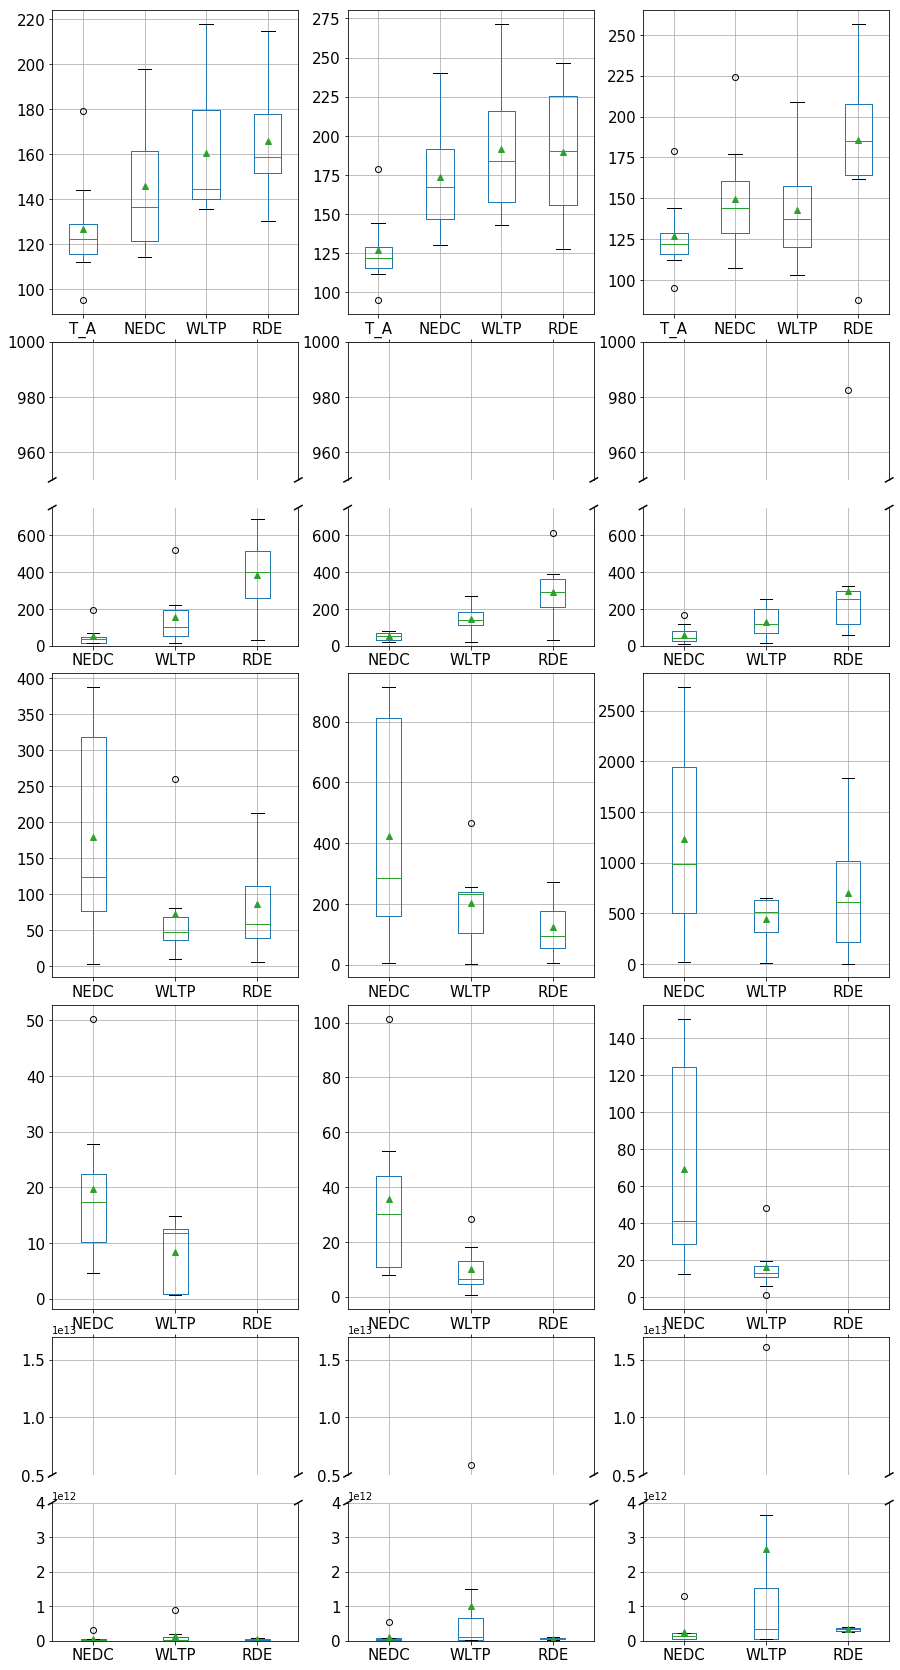

In [116]:
fig = plt.subplots(figsize=(15,30))
gs = gridspec.GridSpec(10, 3)

# CO2
ax00 = plt.subplot(gs[:2, 0])  # comp
ax01 = plt.subplot(gs[:2, 1])  # urb
ax02 = plt.subplot(gs[:2, 2])  # 150

# NOx
ax10a = plt.subplot(gs[2, 0])  # comp
ax10b = plt.subplot(gs[3, 0])
ax11a = plt.subplot(gs[2, 1])  # urb
ax11b = plt.subplot(gs[3, 1])
ax12a = plt.subplot(gs[2, 2])  # 150
ax12b = plt.subplot(gs[3, 2])

# CO
ax20 = plt.subplot(gs[4:6, 0]) # comp
ax21 = plt.subplot(gs[4:6, 1]) # urb
ax22 = plt.subplot(gs[4:6, 2]) # 150

# HC
ax30 = plt.subplot(gs[6:8, 0]) # comp
ax31 = plt.subplot(gs[6:8, 1]) # urb
ax32 = plt.subplot(gs[6:8, 2]) # 150

# PN
ax40a = plt.subplot(gs[8, 0])  # comp
ax40b = plt.subplot(gs[9, 0]) 
ax41a = plt.subplot(gs[8, 1])  # urb
ax41b = plt.subplot(gs[9, 1])
ax42a = plt.subplot(gs[8, 2])  # 150
ax42b = plt.subplot(gs[9, 2])


CO2[CO2['fuel']=='diesel'].boxplot(ax=ax00, showmeans=True, fontsize=15); 
# axes[0,0].set_title('Complete')
CO2_urb[CO2_urb['fuel']=='diesel'].boxplot(ax=ax01, showmeans=True, fontsize=15) 
CO2_150[CO2_150['fuel']=='diesel'].boxplot(ax=ax02, showmeans=True, fontsize=15)

NOx[NOx['fuel']=='diesel'].boxplot(ax=ax10a, showmeans=True, fontsize=15)
NOx_urb[NOx_urb['fuel']=='diesel'].boxplot(ax=ax11a, showmeans=True, fontsize=15)
NOx_150[NOx_150['fuel']=='diesel'].boxplot(ax=ax12a, showmeans=True, fontsize=15)
NOx[NOx['fuel']=='diesel'].boxplot(ax=ax10b, showmeans=True, fontsize=15)
NOx_urb[NOx_urb['fuel']=='diesel'].boxplot(ax=ax11b, showmeans=True, fontsize=15)
NOx_150[NOx_150['fuel']=='diesel'].boxplot(ax=ax12b, showmeans=True, fontsize=15)


CO[CO['fuel']=='diesel'].boxplot(ax=ax20, showmeans=True, fontsize=15); 
CO_urb[CO_urb['fuel']=='diesel'].boxplot(ax=ax21, showmeans=True, fontsize=15) 
CO_150[CO_150['fuel']=='diesel'].boxplot(ax=ax22, showmeans=True, fontsize=15)

HC[HC['fuel']=='diesel'].boxplot(ax=ax30, showmeans=True, fontsize=15) 
HC_urb[HC_urb['fuel']=='diesel'].boxplot(ax=ax31, showmeans=True, fontsize=15) 
HC_150[HC_150['fuel']=='diesel'].boxplot(ax=ax32, showmeans=True, fontsize=15)

PN[PN['fuel']=='diesel'].boxplot(ax=ax40a, showmeans=True, fontsize=15) 
PN_urb[PN_urb['fuel']=='diesel'].boxplot(ax=ax41a, showmeans=True, fontsize=15) 
PN_150[PN_150['fuel']=='diesel'].boxplot(ax=ax42a, showmeans=True, fontsize=15)
PN[PN['fuel']=='diesel'].boxplot(ax=ax40b, showmeans=True, fontsize=15) 
PN_urb[PN_urb['fuel']=='diesel'].boxplot(ax=ax41b, showmeans=True, fontsize=15) 
PN_150[PN_150['fuel']=='diesel'].boxplot(ax=ax42b, showmeans=True, fontsize=15)

# break y-axis
ax10a.set_ylim(950, 1000)
ax10b.set_ylim(0, 750) 
ax11a.set_ylim(950, 1000)
ax11b.set_ylim(0, 750)
ax12a.set_ylim(950, 1000)
ax12b.set_ylim(0, 750)

ax40a.set_ylim(5e12, 1.7e13)
ax40b.set_ylim(0, 4e12) 
ax41a.set_ylim(5e12, 1.7e13)
ax41b.set_ylim(0, 4e12) 
ax42a.set_ylim(5e12, 1.7e13)
ax42b.set_ylim(0, 4e12) 

# make it beautiful NOx
ax10a.spines['bottom'].set_visible(False)
ax10b.spines['top'].set_visible(False)
ax10a.xaxis.tick_top()
ax10a.tick_params(labeltop='off') # don't put tick labels at the top
ax10b.xaxis.tick_bottom()

ax11a.spines['bottom'].set_visible(False)
ax11b.spines['top'].set_visible(False)
ax11a.xaxis.tick_top()
ax11a.tick_params(labeltop='off') # don't put tick labels at the top
ax11b.xaxis.tick_bottom()

ax12a.spines['bottom'].set_visible(False)
ax12b.spines['top'].set_visible(False)
ax12a.xaxis.tick_top()
ax12a.tick_params(labeltop='off') # don't put tick labels at the top
ax12b.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax10a.transAxes, color='k', clip_on=False)
ax10a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax10a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax10b.transAxes)  # switch to the bottom axes
ax10b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax10b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs = dict(transform=ax11a.transAxes, color='k', clip_on=False)
ax11a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax11a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax11b.transAxes)  # switch to the bottom axes
ax11b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax11b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs = dict(transform=ax12a.transAxes, color='k', clip_on=False)
ax12a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax12a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax12b.transAxes)  # switch to the bottom axes
ax12b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax12b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# make it beautiful PN

ax40a.spines['bottom'].set_visible(False)
ax40b.spines['top'].set_visible(False)
ax40a.xaxis.tick_top()
ax40a.tick_params(labeltop='off') # don't put tick labels at the top
ax40b.xaxis.tick_bottom()

ax41a.spines['bottom'].set_visible(False)
ax41b.spines['top'].set_visible(False)
ax41a.xaxis.tick_top()
ax41a.tick_params(labeltop='off') # don't put tick labels at the top
ax41b.xaxis.tick_bottom()

ax42a.spines['bottom'].set_visible(False)
ax42b.spines['top'].set_visible(False)
ax42a.xaxis.tick_top()
ax42a.tick_params(labeltop='off') # don't put tick labels at the top
ax42b.xaxis.tick_bottom()



d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax40a.transAxes, color='k', clip_on=False)
ax40a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax40a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax40b.transAxes)  # switch to the bottom axes
ax40b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax40b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs = dict(transform=ax41a.transAxes, color='k', clip_on=False)
ax41a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax41a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax41b.transAxes)  # switch to the bottom axes
ax41b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax41b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

kwargs = dict(transform=ax42a.transAxes, color='k', clip_on=False)
ax42a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax42a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax42b.transAxes)  # switch to the bottom axes
ax42b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax42b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

### START (150s, in grams)

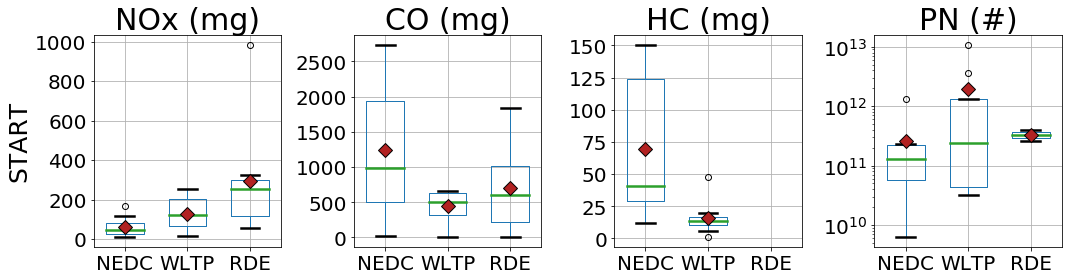

In [78]:
fuel= 'diesel'

widths = 0.6                                                             # box
fs_ticks = 20                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 25                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')


fig, (ax1, ax2, ax3, ax4), = plt.subplots(nrows=1, ncols=4, # sharey='row',
                                         figsize=(15,4))  # sharex='col'

NOx_150[NOx_150['fuel']==fuel].boxplot(ax=ax1, showmeans=True, 
                                           capprops=capprops, meanprops=meanpointprops, medianprops=medianprops,
                                           widths = widths, fontsize=fs_ticks)                           # CHECK outliers
CO_150[CO_150['fuel']==fuel].boxplot(ax=ax2, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                         medianprops=medianprops,
                                         widths = widths, fontsize=fs_ticks)
HC_150[HC_150['fuel']==fuel].boxplot(ax=ax3, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                           medianprops=medianprops, 
                                           fontsize=fs_ticks, widths = widths)
PN_150[PN_150['fuel']==fuel].boxplot(ax=ax4, showmeans=True,capprops=capprops, 
                                         meanprops=meanpointprops, medianprops=medianprops, 
                                         widths = widths, fontsize=fs_ticks)                             # CHECK outliers

# Add datapoints
"""
for i,d in enumerate(NOx_150[['NEDC','WLTP','RDE']][NOx_150['fuel']==fuel]):              
    y = NOx_150[['NEDC','WLTP','RDE']][NOx_150['fuel']==fuel][d]
    x = np.random.normal(i+1, 0.04, len(y))
    ax1.plot(x, y, mfc = ["orange","blue","yellow"][i], mec='k', ms=7, marker="o", linestyle="None")
"""

# 1. NOx
ax1.set_title('NOx (mg)', fontsize=fs_titles)
ax1.set_ylabel('START', fontsize=fs_labels)
ax1.set_yticks([0,200,400,600,800,1000])

# 2. CO
ax2.set_title('CO (mg)', fontsize=fs_titles)
ax2.set_yticks([0,500,1000,1500,2000,2500])

#ax2.set_yticks([0,50,100,150,200,250,300])

# 3. HC
ax3.set_title('HC (mg)', fontsize=fs_titles)
ax3.set_yticks([0,25,50,75,100,125,150])

# 4. PN
ax4.set_title('PN (#)', fontsize=fs_titles)
ax4.set_yscale('log')

fig.tight_layout()

In [76]:
NOx_150[['NEDC','WLTP','RDE']][NOx_150['fuel']==fuel]

,NEDC,WLTP,RDE
BMW 530d,10.613,12.770,135.842
Audi A3,49.352,124.869,66.257
Citroen Cactus,37.031,114.658,229.284
Fiat 500x,165.752,254.388,280.395
Kia Sportage,65.603,198.739,982.401
Peugeot Partner,31.446,83.144,326.030
Porsche Cayenne,118.793,204.764,288.334
VW Golf,9.187,23.400,57.029


## Gasoline

### Targets / standards

In [7]:
fuel = 'gasoline'

In [8]:
if fuel == 'gasoline':
    NOx_lim = 60
    CO_lim = 1000
    PN_lim = 6e11
else:
    NOx_lim = 80
    CO_lim = 500
    PN_lim = 6e11
    
NOx_CF = NOx_lim*2.1
PN_CF = PN_lim*1.5

# 443/2009/EC
CO2_2015 = 130      # target EC for 2015
CO2_2020 = 95       # target EC for 2020


### Complete, urban & start (distance-based)

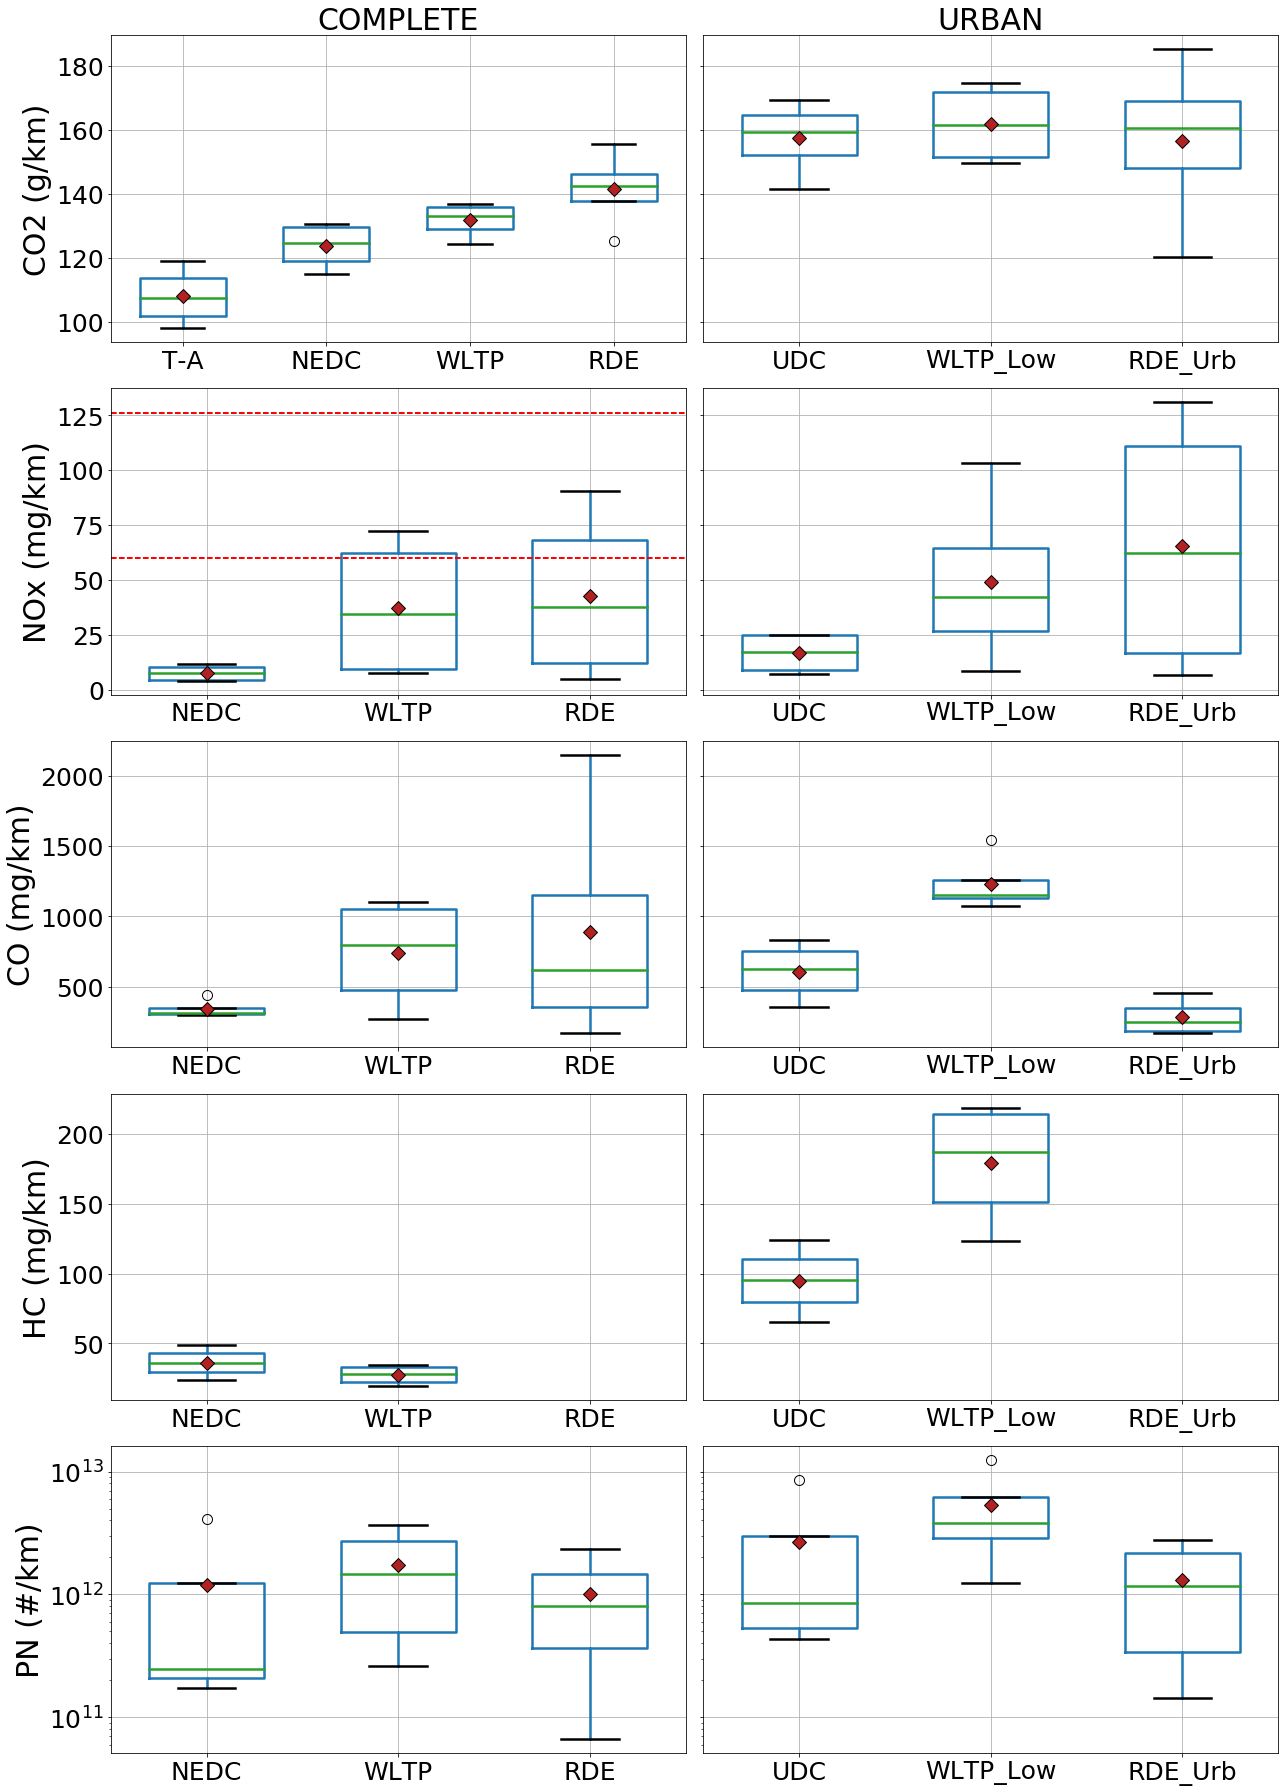

In [9]:
fuel = 'gasoline'

widths = 0.6                                                             # box
fs_ticks = 25                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 30                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')

fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6),
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, sharey='row',
                                         figsize=(18,25))  # sharex='col'

# CO2
CO2[CO2['fuel']==fuel].boxplot(ax=ax1, showmeans=True, 
                                   meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                   capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                   widths = widths, fontsize=25) 
CO2_urb[CO2_urb['fuel']==fuel].boxplot(ax=ax2, showmeans=True, 
                                           medianprops=medianprops, meanprops=meanpointprops, whiskerprops=whiskerprops, 
                                           capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                           widths = widths, fontsize=25) 
# CO2_150d[CO2_150d['fuel']=='diesel'].boxplot(ax=ax3, showmeans=True, widths = widths, capprops=capprops,
#                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# NOx
NOx[NOx['fuel']==fuel].boxplot(ax=ax3, showmeans=True, 
                                   capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                   meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
                                   widths = widths, fontsize=25)
NOx_urb[NOx_urb['fuel']==fuel].boxplot(ax=ax4, showmeans=True, 
                                           capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                           meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                           widths = widths, fontsize=25)
# NOx_150d[NOx_150d['fuel']=='diesel'].boxplot(ax=ax6, showmeans=True, widths = widths, capprops=capprops,
#                                              meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

ax3.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )            # limits
ax3.axhline(y=NOx_CF, color='r', linestyle='--', linewidth=2 )             # conformity factor
#ax4.axhline(y=NOx_lim, color='r', linestyle='--', linewidth=2 )
#ax4.axhline(y=NOx_CF, color='r', linestyle='--', linewidth=2 )



# CO
CO[CO['fuel']==fuel].boxplot(ax=ax5, showmeans=True, 
                                 capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                 meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops, 
                                 widths = widths, fontsize=25); 
CO_urb[CO_urb['fuel']==fuel].boxplot(ax=ax6, showmeans=True, 
                                         capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                         meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                         widths = widths, fontsize=25) 
# CO_150d[CO_150d['fuel']=='diesel'].boxplot(ax=ax9, showmeans=True, widths = widths, capprops=capprops,
#                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# HC
HC[HC['fuel']==fuel].boxplot(ax=ax7, showmeans=True, 
                                 capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                 meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                 widths = widths, fontsize=25) 
HC_urb[HC_urb['fuel']==fuel].boxplot(ax=ax8, showmeans=True, 
                                         capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                         meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                         widths = widths, fontsize=25) 
# HC_150d[HC_150d['fuel']=='diesel'].boxplot(ax=ax12, showmeans=True, widths = widths, capprops=capprops,
#                                            meanprops=meanpointprops, medianprops=medianprops, fontsize=25)

# PN
PN[PN['fuel']==fuel].boxplot(ax=ax9, showmeans=True, 
                                 capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                 meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                 widths = widths, fontsize=25) 
PN_urb[PN_urb['fuel']==fuel].boxplot(ax=ax10, showmeans=True, 
                                         capprops=capprops, flierprops=flierprops, boxprops=boxprops,
                                         meanprops=meanpointprops, medianprops=medianprops, whiskerprops=whiskerprops,
                                         widths = widths, fontsize=25)                              # CHECK outliers!
# PN_150d[PN_150d['fuel']=='diesel'].boxplot(ax=ax15, showmeans=True, showfliers=False, capprops=capprops,
#                                            meanprops=meanpointprops, medianprops=medianprops,
#                                         widths = widths, fontsize=25)                            # CHECK outliers!



# 3 columns
ax1.set_title('COMPLETE', fontsize=30)
ax2.set_title('URBAN', fontsize=30)
#ax3.set_title('START', fontsize=30)

# 5 rows
ax1.set_ylabel('CO2 (g/km)', fontsize=30)
ax3.set_ylabel('NOx (mg/km)', fontsize=30)
ax5.set_ylabel('CO (mg/km)', fontsize=30)
ax7.set_ylabel('HC (mg/km)', fontsize=30)
ax9.set_ylabel('PN (#/km)', fontsize=30)
ax9.set_yscale('log')
ax10.set_yscale('log')


fig.tight_layout()

In [15]:
pd.set_option('display.float_format', lambda x: '%.3e' % x)
PN[PN['fuel']==fuel].describe()

,NEDC,WLTP,RDE
count,4.000e+00,4.000e+00,4.000e+00
mean,1.189e+12,1.725e+12,1.010e+12
std,1.931e+12,1.607e+12,1.006e+12
min,1.739e+11,2.630e+11,6.668e+10
25%,2.071e+11,4.976e+11,3.650e+11
50%,2.481e+11,1.473e+12,8.067e+11
75%,1.230e+12,2.701e+12,1.452e+12
max,4.084e+12,3.692e+12,2.362e+12


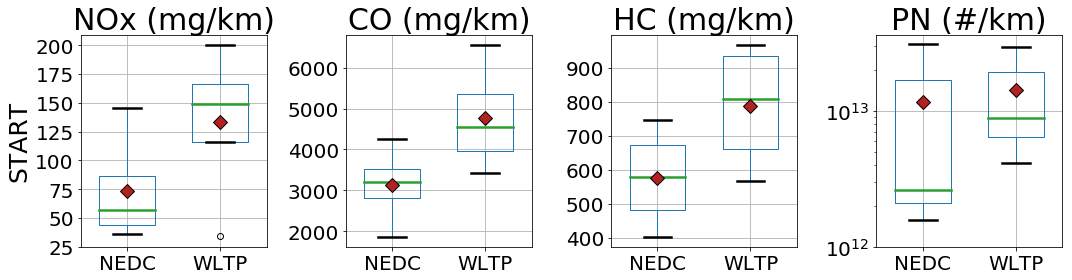

In [87]:
fuel = 'gasoline'

widths = 0.6                                                             # box
fs_ticks = 20                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 25                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')


fig, (ax1, ax2, ax3, ax4), = plt.subplots(nrows=1, ncols=4, # sharey='row',
                                         figsize=(15,4))  # sharex='col'

NOx_150d[NOx_150d['fuel']==fuel].boxplot(ax=ax1, showmeans=True, 
                                           capprops=capprops, meanprops=meanpointprops, medianprops=medianprops,
                                           widths = widths, fontsize=fs_ticks)                           # CHECK outliers
CO_150d[CO_150d['fuel']==fuel].boxplot(ax=ax2, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                         medianprops=medianprops,
                                         widths = widths, fontsize=fs_ticks)
HC_150d[HC_150d['fuel']==fuel].boxplot(ax=ax3, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                           medianprops=medianprops, 
                                           fontsize=fs_ticks, widths = widths)
PN_150d[PN_150d['fuel']==fuel].boxplot(ax=ax4, showmeans=True,capprops=capprops, 
                                         meanprops=meanpointprops, medianprops=medianprops, 
                                         widths = widths, fontsize=fs_ticks)                             # CHECK outliers

# 1. NOx
ax1.set_title('NOx (mg/km)', fontsize=fs_titles)
ax1.set_ylabel('START', fontsize=fs_labels)
ax1.set_yticks([25,50,75,100,125,150,175,200])

# 2. CO
ax2.set_title('CO (mg/km)', fontsize=fs_titles)
ax2.set_yticks([2000,3000,4000,5000,6000])

# 3. HC
ax3.set_title('HC (mg/km)', fontsize=fs_titles)
ax3.set_yticks([400,500,600,700,800,900])

# 4. PN
ax4.set_title('PN (#/km)', fontsize=fs_titles)
ax4.set_yscale('log')
ax4.set_yticks([1e12,1e13])
#ax4.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


fig.tight_layout()

### START (150s, in grams)

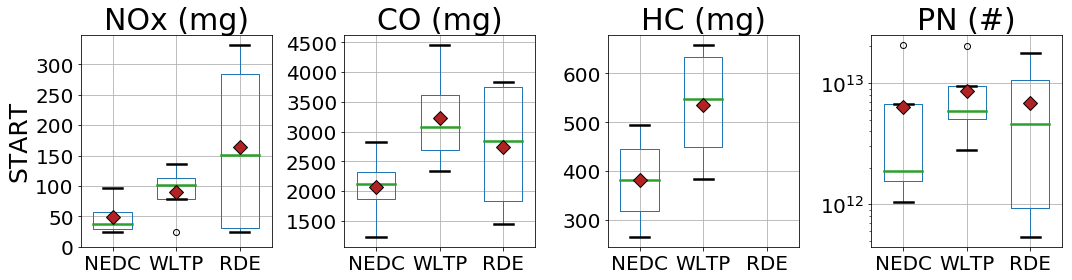

In [5]:
fuel = 'gasoline'

widths = 0.6                                                             # box
fs_ticks = 20                                                            # fonstize ticks  
fs_titles = 30                                                           # fontsize titles
fs_labels = 25                                                           # fontsize axis labels

medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')      # median
meanpointprops = dict(marker='D', markeredgecolor='black',               # mean
                      markerfacecolor='firebrick', markersize = 10)
capprops = dict(linewidth=2.5)
whiskerprops = dict(linewidth=2.5, color='black')
flierprops = dict(markersize = 10)
boxprops = dict(linestyle='-', linewidth=2.5, color='black')


fig, (ax1, ax2, ax3, ax4), = plt.subplots(nrows=1, ncols=4, # sharey='row',
                                         figsize=(15,4))  # sharex='col'

NOx_150[NOx_150['fuel']==fuel].boxplot(ax=ax1, showmeans=True, 
                                           capprops=capprops, meanprops=meanpointprops, medianprops=medianprops,
                                           widths = widths, fontsize=fs_ticks)                           # CHECK outliers
CO_150[CO_150['fuel']==fuel].boxplot(ax=ax2, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                         medianprops=medianprops,
                                         widths = widths, fontsize=fs_ticks)
HC_150[HC_150['fuel']==fuel].boxplot(ax=ax3, showmeans=True,capprops=capprops, meanprops=meanpointprops,
                                           medianprops=medianprops, 
                                           fontsize=fs_ticks, widths = widths)
PN_150[PN_150['fuel']==fuel].boxplot(ax=ax4, showmeans=True,capprops=capprops, 
                                         meanprops=meanpointprops, medianprops=medianprops, 
                                         widths = widths, fontsize=fs_ticks)                             # CHECK outliers

# 1. NOx
ax1.set_title('NOx (mg)', fontsize=fs_titles)
ax1.set_ylabel('START', fontsize=fs_labels)
ax1.set_yticks([0,50,100,150,200,250,300])

# 2. CO
ax2.set_title('CO (mg)', fontsize=fs_titles)
ax2.set_yticks([1500,2000,2500,3000,3500,4000,4500])

# 3. HC
ax3.set_title('HC (mg)', fontsize=fs_titles)
#ax3.set_yticks([0,25,50,75,100,125,150])

# 4. PN
ax4.set_title('PN (#)', fontsize=fs_titles)
ax4.set_yscale('log')
#ax4.set_yticks([6e11,1e12,5e12,1e13])
#ax4.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


fig.tight_layout()

# Other data about pollutants

## CO2

In [25]:
# COMPLETE

pd.set_option('display.precision',3)
ESP = vehicles['ESP','CO2']
LAB = vehicles['LAB','CO2']
NEDC = vehicles['N_CD_23','CO2']
WLTP = vehicles['W_CD_23','CO2']

CO2 = pd.concat([NEDC, WLTP, ESP, LAB], axis=1)
CO2.columns = ['NEDC','WLTP','ESP','LAB']

RDE = CO2[["ESP", "LAB"]].mean(axis=1)

CO2 = pd.concat([NEDC, WLTP, RDE], axis=1)
CO2['fuel'] = vehicles['fuel']
CO2.columns = ['NEDC','WLTP','RDE','fuel']

CO2['T_A'] = vehicles['TA_CO2']
CO2.columns = ['NEDC','WLTP','RDE','fuel','T_A']

CO2_mean = CO2.groupby(CO2.fuel).mean()
CO2_mean.columns = ['NEDC','WLTP','RDE','T_A']
CO2_mean.describe()

CO2_mean['NEDC/T_A'] = CO2_mean.NEDC/CO2_mean.T_A
CO2_mean['ESP/T_A'] = CO2_mean.WLTP/CO2_mean.T_A 
CO2_mean['LAB/T_A'] = CO2_mean.RDE/CO2_mean.T_A
CO2_mean.columns = ['NEDC','ESP','LAB','T_A','NEDC/T_A','WLTP/T_A','RDE/T_A']
CO2_mean
# NOx[NOx['fuel'] == 'diesel'].describe()


D:\Apps\co2mpas_AIO-1.7.3\Apps\WinPython\python-3.6.1.amd64\lib\site-packages\ipykernel\kernelbase.py:390: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,NEDC,ESP,LAB,T_A,NEDC/T_A,WLTP/T_A,RDE/T_A
fuel,,,,,,,
diesel,147.778,164.260,168.143,131.250,1.126,1.252,1.281
gasoline,123.271,133.094,136.682,106.667,1.156,1.248,1.281


In [ ]:
# URBAN

#pd.set_option('display.precision',3)
ESP = vehicles['ESP','CO2_urb']
LAB = vehicles['LAB','CO2_urb']
NEDC = vehicles['N_CD_23','CO2_urb']
WLTP = vehicles['W_CD_23','CO2_urb']


CO2 = pd.concat([NEDC, WLTP, ESP, LAB], axis=1)
CO2.columns = ['NEDC_urb','WLTP_urb','ESP_urb','LAB_urb']

RDE = CO2[["ESP_urb", "LAB_urb"]].mean(axis=1)

CO2 = pd.concat([NEDC, WLTP, RDE], axis=1)
CO2['fuel'] = vehicles['fuel']
CO2.columns = ['NEDC_urb','WLTP_urb','RDE_urb','fuel']

CO2['T_A'] = vehicles['TA_CO2']
CO2.columns = ['NEDC_urb','WLTP_urb','RDE_urb','fuel','T_A']



CO2_mean = CO2.groupby(CO2.fuel).mean()
CO2_mean.columns = ['NEDC_urb','WLTP_urb','RDE_urb','T_A']
CO2_mean.describe()

CO2_mean['NEDC_urb/T_A'] = CO2_mean.NEDC_urb/CO2_mean.T_A
CO2_mean['ESP_urb/T_A'] = CO2_mean.WLTP_urb/CO2_mean.T_A 
CO2_mean['LAB_urb/T_A'] = CO2_mean.RDE_urb/CO2_mean.T_A
CO2_mean.columns = ['NEDC_urb','WLTP_urb','RDE_urb','T_A','NEDC_urb/T_A','WLTP_urb/T_A','RDE_urb/T_A']
CO2_mean
# NOx[NOx['fuel'] == 'diesel'].describe()
#CO2

## NOx

### NOx emissions  - compare to standards DELPHI

In [ ]:
diesel_std = 80 # mg/km
gasol_std = 60  # mg/km
CF = 2.1        # conformity factor (temp.)

pd.set_option('display.precision',3)
ESP = tests_extended['ESP','NOx']
LAB = tests_extended['LAB','NOx']
NEDC = tests_extended['N_CD_23','NOx']
WLTP = tests_extended['W_CD_23','NOx']


NOx = pd.concat([NEDC, WLTP, ESP, LAB], axis=1)

NOx.columns = ['NEDC','WLTP','ESP','LAB']
RDE = NOx[["ESP", "LAB"]].mean(axis=1)

NOx = pd.concat([NEDC, WLTP, RDE], axis=1)
NOx['fuel'] = tests_extended['fuel']
NOx.columns = ['NEDC','WLTP','RDE','fuel']#,'fuel']

NOx_mean = NOx.groupby(NOx.fuel).mean()
NOx_mean['limit'] = [diesel_std*CF, gasol_std*CF]
NOx_mean.columns = ['NEDC','WLTP','RDE','limit']
NOx_mean.describe()
NOx_mean

NOx_mean['NEDC/lim'] = NOx_mean.NEDC/(NOx_mean.limit) 
NOx_mean['WLTP/lim'] = NOx_mean.WLTP/(NOx_mean.limit)
NOx_mean['RDE/lim'] = NOx_mean.RDE/(NOx_mean.limit)
NOx_mean.columns = ['NEDC','WLTP','RDE','standards','NEDC/lim','WLTP/lim','RDE/lim']
NOx_mean


In [ ]:
diesel_std = 80 #mg/km
gasol_std = 60 #mg/km
CF = 2.1        # conformity factor (temp.)

pd.set_option('display.precision',3)
ESP = tests_extended['ESP','NOx_urb']
LAB = tests_extended['LAB','NOx_urb']
NEDC = tests_extended['N_CD_23','NOx_urb']
WLTP = tests_extended['W_CD_23','NOx_urb']

NOx_urb = pd.concat([NEDC, WLTP, ESP, LAB], axis=1)

NOx_urb.columns = ['NEDC','WLTP','ESP','LAB']
RDE = NOx_urb[["ESP", "LAB"]].mean(axis=1)

NOx_urb = pd.concat([NEDC, WLTP, RDE], axis=1)
NOx_urb['fuel'] = tests_extended['fuel']
NOx_urb.columns = ['NEDC','WLTP','RDE','fuel']#,'fuel']

NOx_mean = NOx_urb.groupby(NOx_urb.fuel).mean()
NOx_mean['limit'] = [diesel_std*CF, gasol_std*CF]
NOx_mean.columns = ['NEDC_urb','WLTP_urb','RDE_urb','limit']
NOx_mean.describe()
NOx_mean

NOx_mean['NEDC/lim'] = NOx_mean.NEDC_urb/(NOx_mean.limit) 
NOx_mean['WLTP/lim'] = NOx_mean.WLTP_urb/(NOx_mean.limit)
NOx_mean['RDE/lim'] = NOx_mean.RDE_urb/(NOx_mean.limit)
NOx_mean.columns = ['NEDC_urb','WLTP_urb','RDE_urb','limit','NEDC/lim','WLTP/lim','RDE/lim']
NOx_mean

## CO

## THC

### Diesel

### Gasoline

## PN

In [ ]:
### DELPHI: Until 3 years after the dates for TA/FR (??), part. emission limit of 6E12 may be applied
###          for Euro 6 positive ignition DI (direct ignition, GDI) vehicles upon request of the manufacturer

PN_std = 6e11    #/km  # limit
PN_CF = 1.5            # conformity factor  
PN_lim = PN_std*PN_CF

ERMES_PFI = 3.6e11  # proposed by ERMES for Euro 6 - PFI ---> Astra and Panda
ERMES_GDI = 2e12    # proposed by ERMES for Euro 6 - PFI ---> Audi A1

pd.set_option('display.precision',3)
ESP = vehicles['ESP','PN_urb']
LAB = vehicles['LAB','PN_urb']
NEDC = vehicles['N_CD_23','PN_urb']
WLTP = vehicles['W_CD_23','PN_urb']

PN = pd.concat([NEDC, WLTP, ESP, LAB], axis=1)
PN.columns = ['NEDC','WLTP','ESP','LAB']


RDE = PN[["ESP", "LAB"]].mean(axis=1)

PN = pd.concat([NEDC, WLTP, RDE], axis=1)
PN['fuel'] = vehicles['fuel']
PN.columns = ['NEDC','WLTP','RDE','fuel']

PN_mean = PN.groupby(PN.fuel).mean()
PN_mean['limit'] = [PN_lim, PN_lim]
PN_mean.columns = ['NEDC_urb','WLTP_urb','RDE_urb','limit']
PN_mean.describe()
PN_mean

PN_mean['NEDC_urb/lim'] = PN_mean.NEDC_urb/(PN_mean.limit) 
PN_mean['WLTP_urb/lim'] = PN_mean.WLTP_urb/(PN_mean.limit)
PN_mean['RDE_urb/lim'] = PN_mean.RDE_urb/(PN_mean.limit)
PN_mean.columns = ['NEDC_urb','WLTP_urb','RDE_urb','limit','NEDC_urb/lim','WLTP_urb/lim','RDE_urb/lim']

PN_mean
PN
# NOx[NOx['fuel'] == 'diesel'].describe()

In [ ]:
### DELPHI: Until 3 years after the dates for TA/FR (??), part. emission limit of 6E12 may be applied
###          for Euro 6 positive ignition DI (direct ignition, GDI) vehicles upon request of the manufacturer

PN_std = 6e11    #/km  # limit
PN_CF = 1.5            # conformity factor  
PN_lim = PN_std*PN_CF
#PN_

pd.set_option('display.precision',3)
ESP = vehicles['ESP','PN']
LAB = vehicles['LAB','PN']
NEDC = vehicles['N_CD_23','PN']
WLTP = vehicles['W_CD_23','PN']

PN = pd.concat([NEDC, WLTP, ESP, LAB], axis=1)
PN.columns = ['NEDC','WLTP','ESP','LAB']


RDE = PN[["ESP", "LAB"]].mean(axis=1)

PN = pd.concat([NEDC, WLTP, RDE], axis=1)
PN['fuel'] = vehicles['fuel']
PN.columns = ['NEDC','WLTP','RDE','fuel']

PN_mean = PN.groupby(PN.fuel).mean()
PN_mean['limit'] = [PN_lim, PN_lim]
PN_mean.columns = ['NEDC','WLTP','RDE','limit']
PN_mean.describe()
PN_mean

PN_mean['NEDC/lim'] = PN_mean.NEDC/(PN_mean.limit) 
PN_mean['WLTP/lim'] = PN_mean.WLTP/(PN_mean.limit)
PN_mean['RDE/lim'] = PN_mean.RDE/(PN_mean.limit)
PN_mean.columns = ['NEDC','WLTP','RDE','limit','NEDC/lim','WLTP/lim','RDE/lim']

PN_mean

# NOx[NOx['fuel'] == 'diesel'].describe()
PN

### Diesel

In [ ]:
ERMES_diesel = 9.3e11  # proposed by ERMES for Euro 6 - PFI ---> Astra and Panda

ax = PN[PN['fuel'] == 'diesel'].boxplot(showmeans=True) #, meanline=True)
plt.axhline(y=ERMES_diesel, color='b', linestyle='--', linewidth=2 )
#plt.axhline(y=ERMES_PFI, color='b', linestyle='--', linewidth=2 )
plt.axhline(y=PN_lim, color='r', linestyle='--', linewidth=2 )

# # demonstrate how to customize the display different elements:
# boxprops = dict(linestyle='--', linewidth=3, color='darkgoldenrod')
# flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
#                   linestyle='none')
# medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
# meanpointprops = dict(marker='D', markeredgecolor='black',
#                       markerfacecolor='firebrick')
# meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

ax.set_xlabel('Test', fontsize = 14)
ax.set_ylabel('PN (#/km)', fontsize = 14)
ax.set_title('PN total emissions - gasoline', fontsize = 18)
ax.annotate('ERMES PFI = 9.3e11' ,(0.55,0.94e13), color='b', fontsize=14, clip_on=True)
ax.annotate('PN lim = 9e11' ,(0.55, 0.91e13), color='r', fontsize=14, clip_on=True)
#ax.annotate('ERMES GDI = 2e12' ,(0.55, 1.11e13), color='b', fontsize=14, clip_on=True)

PN[PN['fuel'] == 'diesel'].describe()

### Gasoline

,NEDC,WLTP,RDE
count,2.000e+00,3.000e+00,2.000e+00
mean,4.790e+11,2.108e+12,1.755e+12
std,4.313e+11,1.728e+12,8.556e+11
min,1.740e+11,2.630e+11,1.150e+12
25%,3.265e+11,1.316e+12,1.452e+12
50%,4.790e+11,2.370e+12,1.755e+12
75%,6.315e+11,3.030e+12,2.058e+12
max,7.840e+11,3.690e+12,2.360e+12


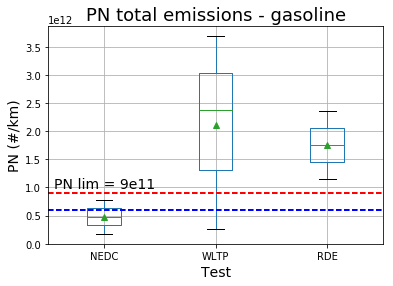

In [10]:
ax = PN[PN['fuel'] == 'gasoline'].boxplot(showmeans=True) #, meanline=True)
plt.axhline(y=PN_std, color='b', linestyle='--', linewidth=2 )
plt.axhline(y=PN_lim, color='r', linestyle='--', linewidth=2 )

# # demonstrate how to customize the display different elements:
# boxprops = dict(linestyle='--', linewidth=3, color='darkgoldenrod')
# flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
#                   linestyle='none')
# medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
# meanpointprops = dict(marker='D', markeredgecolor='black',
#                       markerfacecolor='firebrick')
# meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

ax.set_xlabel('Test', fontsize = 14)
ax.set_ylabel('PN (#/km)', fontsize = 14)
ax.set_title('PN total emissions - gasoline', fontsize = 18)
ax.annotate('PN lim = 9e11' ,(0.55, PN_lim + 0.1*PN_lim),fontsize=14, clip_on=True)


PN[PN['fuel'] == 'gasoline'].describe()

,NEDC,WLTP,RDE
count,2.000e+00,3.000e+00,2.000e+00
mean,7.873e+11,5.935e+12,2.359e+12
std,5.033e+11,5.753e+12,5.738e+11
min,4.314e+11,1.232e+12,1.953e+12
25%,6.094e+11,2.727e+12,2.156e+12
50%,7.873e+11,4.222e+12,2.359e+12
75%,9.653e+11,8.286e+12,2.562e+12
max,1.143e+12,1.235e+13,2.764e+12


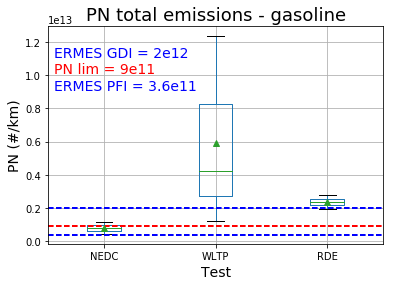

In [35]:
ax = PN[PN['fuel'] == 'gasoline'].boxplot(showmeans=True) #, meanline=True)
plt.axhline(y=ERMES_GDI, color='b', linestyle='--', linewidth=2 )
plt.axhline(y=ERMES_PFI, color='b', linestyle='--', linewidth=2 )
plt.axhline(y=PN_lim, color='r', linestyle='--', linewidth=2 )

# # demonstrate how to customize the display different elements:
# boxprops = dict(linestyle='--', linewidth=3, color='darkgoldenrod')
# flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
#                   linestyle='none')
# medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
# meanpointprops = dict(marker='D', markeredgecolor='black',
#                       markerfacecolor='firebrick')
# meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

ax.set_xlabel('Test', fontsize = 14)
ax.set_ylabel('PN (#/km)', fontsize = 14)
ax.set_title('PN total emissions - gasoline', fontsize = 18)
ax.annotate('ERMES PFI = 3.6e11' ,(0.55,0.91e13), color='b', fontsize=14, clip_on=True)
ax.annotate('PN lim = 9e11' ,(0.55, 1.01e13), color='r', fontsize=14, clip_on=True)
ax.annotate('ERMES GDI = 2e12' ,(0.55, 1.11e13), color='b', fontsize=14, clip_on=True)

PN[PN['fuel'] == 'gasoline'].describe()

# Extra

In [12]:
""" Bar plot example """

pd.set_option('display.precision',2)
NOx_NCD23 = vehicles['W_CD_23']['NOx']
NOx_NCD23.plot(kind = 'bar',figsize=(12,8),grid = 'on')

NameError: name 'vehicles' is not defined

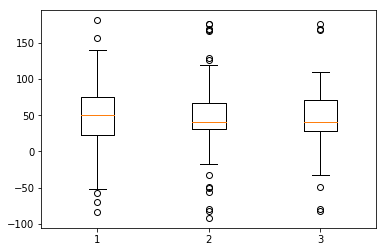

In [11]:
""" Box plot example """

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low), 0)

# fake up some more data
spread = np.random.rand(50) * 100
center = np.ones(25) * 40
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
d2 = np.concatenate((spread, center, flier_high, flier_low), 0)
data.shape = (-1, 1)
d2.shape = (-1, 1)
# data = concatenate( (data, d2), 1 )
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
data = [data, d2, d2[::2, 0]]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)

plt.show()